In [1]:
import os
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats  as ss
from statsmodels.api import ProbPlot


warnings.filterwarnings(action = 'ignore')

In [2]:
train_transaction = pd.read_csv("../dataset/train_transaction.csv")
train_identity = pd.read_csv("../dataset/train_identity.csv")

test_transaction = pd.read_csv("../dataset/test_transaction.csv")
test_identity = pd.read_csv("../dataset/test_identity.csv")

In [3]:
%run DataPrepare.ipynb

In [4]:
train_df = pd.merge(left=train_transaction,right=train_identity,how='left',on = 'TransactionID')

In [5]:
del train_transaction, train_identity
gc.collect()

33

In [6]:
# Reduce_Memory_Usage(train_df)

In [7]:
# 类别、离散特征
cate_col_list = ['ProductCD','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','addr1','addr2']

#循环加入特征
for i in range(1,7):
    cate_col_list.append('card' + str(i))
for i in range(1 ,10):
    cate_col_list.append('M' + str(i))
for i in range(12 ,39):
    cate_col_list.append('id_' + str(i // 10) + str(i % 10))
#连续型特征
cont_col_list = [x for x in train_df.columns if x not in cate_col_list]
cont_col_list.remove('isFraud')

# Handle Missing data

In [8]:
missing_col_list = list(train_df.columns[train_df.isnull().sum() > 0])

In [9]:
train_df.isnull().sum() > 0

TransactionID     False
isFraud           False
TransactionDT     False
TransactionAmt    False
ProductCD         False
                  ...  
id_36              True
id_37              True
id_38              True
DeviceType         True
DeviceInfo         True
Length: 434, dtype: bool

In [10]:
%run Cleaning_utils.ipynb

In [11]:
%run EDA_utils.ipynb

In [12]:
%run Featrue_Engineering_utils.ipynb

# Plan A: 先处理Outliers 再处理Missing Values

根据features的特性采用IQR和μ±3*σ的方式来检测异常值，和相适应的Outliers处理方法

In [13]:
print(cate_col_list , end= "")

['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

## Feature ——ProductCD

ProductCD is a categorical feature  and it may be the types of Product.

The value type of ProductCD is string, so, we should finish encoding of it.

Then, detect  whether outliers exist in it by IQR method

In [14]:
#values of ProductCD
print(train_df['ProductCD'].value_counts(), '\n')

print("Total Nan values of 'Product' is: {}".format(train_df['ProductCD'].isnull().sum()))

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64 

Total Nan values of 'Product' is: 0


In [15]:
# encoding 'ProductCD' with Sklearn Lablel encoder
train_df['ProductCD'] = Encoder_With_Label(train_df, col='ProductCD')

In [16]:
train_df['ProductCD'].value_counts()

4.0    439670
0.0     68519
2.0     37699
1.0     33024
3.0     11628
Name: ProductCD, dtype: int64

1. when median as the foundment value

1.1 the upper bound value is 5.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 2.5
1.5 the potential outliers below 1.5IQR amount is : 139242
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              68519
2.0              37699
1.0              33024
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 4.720757246017456
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 1.720757246017456
2.5 the potential outliers below 1.5IQR amount is : 101543
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              68

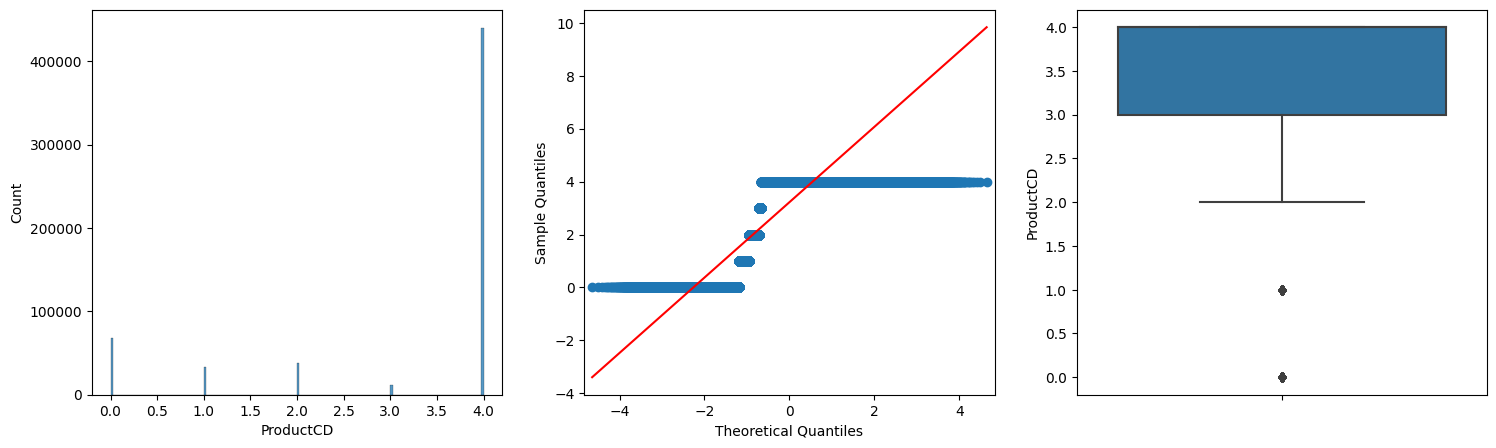

In [17]:
Outlier_Detect_IQR(data = train_df, col = 'ProductCD')

after encoding, the total value types is 4,so, this feature 'ProductCD' may not follow normal distribution

Next, we should plot IQR figure to check whether there are some  Outliers

In [18]:
#according to analysis above , 0,1,2 may be outliers, 
#but the total percentage of 0, 1, 2 is more than 20%, so nothing to do may be better
train_df['ProductCD'].value_counts(normalize=True)

4.0    0.744522
0.0    0.116028
2.0    0.063838
1.0    0.055922
3.0    0.019690
Name: ProductCD, dtype: float64

## P_emaildomain
- this feature may be the domian of user sign up email. 

- according to P_emaildomain,we can  know what speculate operators are popular.

In [19]:
#values of P_emaildomain are string type, so, encoding P_emaildomain is the first step
train_df['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [20]:
#P_emaildomain contains  Nan  values, 
print("{} contain {} Nan values".format('P_emaildomain',train_df['P_emaildomain'].isnull().sum()))

P_emaildomain contain 94456 Nan values


In [21]:
#encoding P_emaildomain with labelencoder,
train_df['P_emaildomain'] = Encoder_With_Label(train_df,'P_emaildomain')

1. when median as the foundment value

1.1 the upper bound value is 38.5
1.2 the potential outliers above 1.5IQR amount is : 113431
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
54.0             100934
44.0               2970
49.0               2705
59.0               2396
55.0               1543
43.0                664
42.0                305
51.0                305
50.0                240
48.0                230
41.0                189
47.0                175
45.0                164
58.0                143
57.0                134
39.0                 76
56.0                 74
40.0                 68
53.0                 49
46.0                 35
52.0                 32
dtype: int64
1.4 the lower bound value is -6.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
--------------------------------------------------------------------------------------------

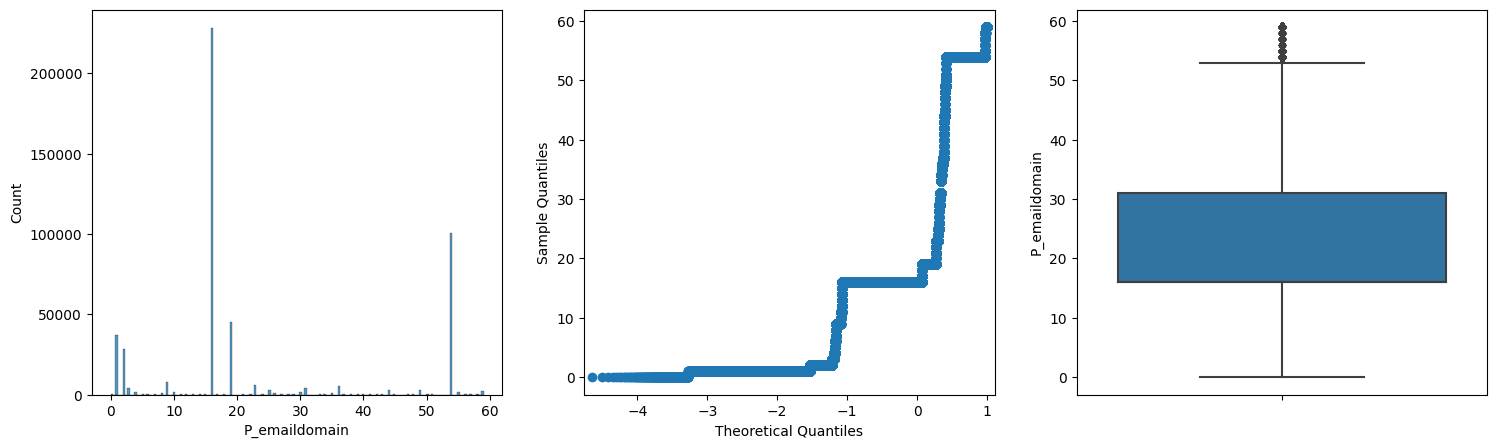

In [22]:
Outlier_Detect_IQR(train_df, 'P_emaildomain')

In [23]:
#check values of P_emaildomain and value distribution
train_df['P_emaildomain'].value_counts(normalize=True,ascending=True)

52.0    0.000065
46.0    0.000071
20.0    0.000087
53.0    0.000099
27.0    0.000113
40.0    0.000137
56.0    0.000149
39.0    0.000153
18.0    0.000226
57.0    0.000270
58.0    0.000288
17.0    0.000300
5.0     0.000321
45.0    0.000331
7.0     0.000347
47.0    0.000353
41.0    0.000381
14.0    0.000393
34.0    0.000395
6.0     0.000413
38.0    0.000417
48.0    0.000464
33.0    0.000464
50.0    0.000484
12.0    0.000524
13.0    0.000564
22.0    0.000595
21.0    0.000615
51.0    0.000615
42.0    0.000615
0.0     0.000635
24.0    0.000649
28.0    0.000879
37.0    0.000883
15.0    0.001000
11.0    0.001036
29.0    0.001127
43.0    0.001338
26.0    0.001510
8.0     0.001645
35.0    0.002038
10.0    0.002808
30.0    0.003068
55.0    0.003110
4.0     0.003848
59.0    0.004830
49.0    0.005453
44.0    0.005987
25.0    0.006130
3.0     0.008130
31.0    0.008249
36.0    0.010272
23.0    0.012633
9.0     0.015901
2.0     0.057025
1.0     0.074580
19.0    0.091214
54.0    0.203462
16.0    0.4603

after encoding of P_emaildomain ,54 may be a Outliers through IQR method
but, it take second percentage. So ,we can process this feature by rare feature method

## R_emaildomain

- this feature is similar to P_emaildomain
- encoding is first step, then check Outliers

In [24]:
train_df['R_emaildomain'].value_counts(normalize=True, ascending=False)

gmail.com           0.416247
hotmail.com         0.200370
anonymous.com       0.149529
yahoo.com           0.086255
aol.com             0.026957
outlook.com         0.018260
comcast.net         0.013198
yahoo.com.mx        0.010984
icloud.com          0.010183
msn.com             0.006206
live.com            0.005550
live.com.mx         0.005492
verizon.net         0.004516
me.com              0.004050
sbcglobal.net       0.004021
cox.net             0.003343
outlook.es          0.003154
att.net             0.003132
bellsouth.net       0.003074
hotmail.fr          0.002134
hotmail.es          0.002127
web.de              0.001726
mac.com             0.001588
prodigy.net.mx      0.001508
ymail.com           0.001508
optonline.net       0.001362
gmx.de              0.001071
yahoo.fr            0.000998
charter.net         0.000925
mail.com            0.000889
hotmail.co.uk       0.000765
gmail               0.000692
earthlink.net       0.000575
yahoo.de            0.000546
rocketmail.com

In [25]:
#encoding with labelencoder
train_df['R_emaildomain'] = Encoder_With_Label(train_df, 'R_emaildomain')

1. when median as the foundment value

1.1 the upper bound value is 20.5
1.2 the potential outliers above 1.5IQR amount is : 24441
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
55.0             11842
36.0              2507
56.0              1508
23.0              1398
31.0               852
25.0               762
26.0               754
50.0               620
30.0               556
44.0               552
37.0               433
22.0               293
21.0               292
51.0               237
28.0               218
38.0               207
60.0               207
35.0               187
59.0               137
29.0               122
57.0                75
43.0                69
46.0                63
58.0                57
27.0                55
24.0                53
42.0                53
52.0                47
39.0                41
54.0                39
47.0                35
53.0                33
49.0                29
40.0                27
48.0   

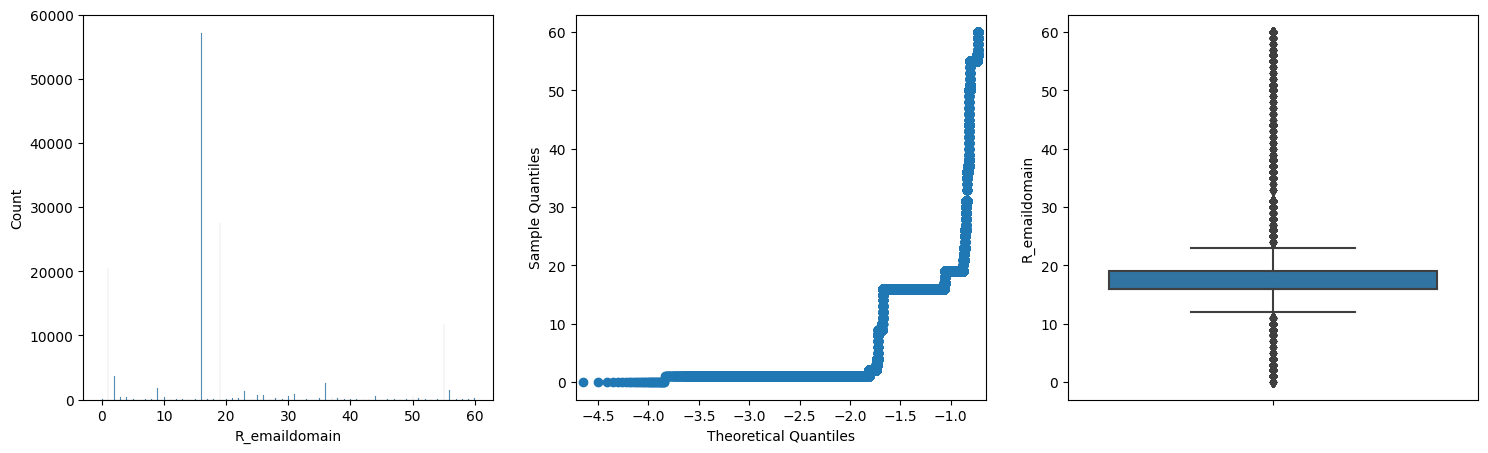

In [26]:
Outlier_Detect_IQR(train_df, 'R_emaildomain')

because it original values are string type and labelencoder has randomness, Outliers detected by IQR 
may not be Outliers.

so we decide process this feature as rare feature

## DeviceType

In [27]:
train_df['DeviceType'].value_counts(normalize=True)

desktop    0.604822
mobile     0.395178
Name: DeviceType, dtype: float64

DeviceType only has two values, so  we just encoding it with binaryencoder


## DeviceInfo
deviceinfo may be the information about user device

In [28]:
train_df['DeviceInfo'].value_counts(normalize=True)

Windows        0.402154
iOS Device     0.166703
MacOS          0.105953
Trident/7.0    0.062697
rv:11.0        0.016020
                 ...   
E5306          0.000008
ME301T         0.000008
GT-S7582L      0.000008
SM-T818V       0.000008
ATT            0.000008
Name: DeviceInfo, Length: 1786, dtype: float64

In [29]:
#DeviceInfo has many Nan value
train_df['DeviceInfo'].isnull().sum()

471874

In [30]:
#encode DeviceInfo firstly
train_df['DeviceInfo'] = Encoder_With_Label(train_df, col = 'DeviceInfo')

1. when median as the foundment value

1.1 the upper bound value is 2210.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 986.0
1.5 the potential outliers below 1.5IQR amount is : 26403
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
723.0            12573
81.0               312
927.0              235
752.0              219
205.0              172
                 ...  
359.0                1
360.0                1
361.0                1
363.0                1
0.0                  1
Length: 986, dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1988.8135986328125
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int6

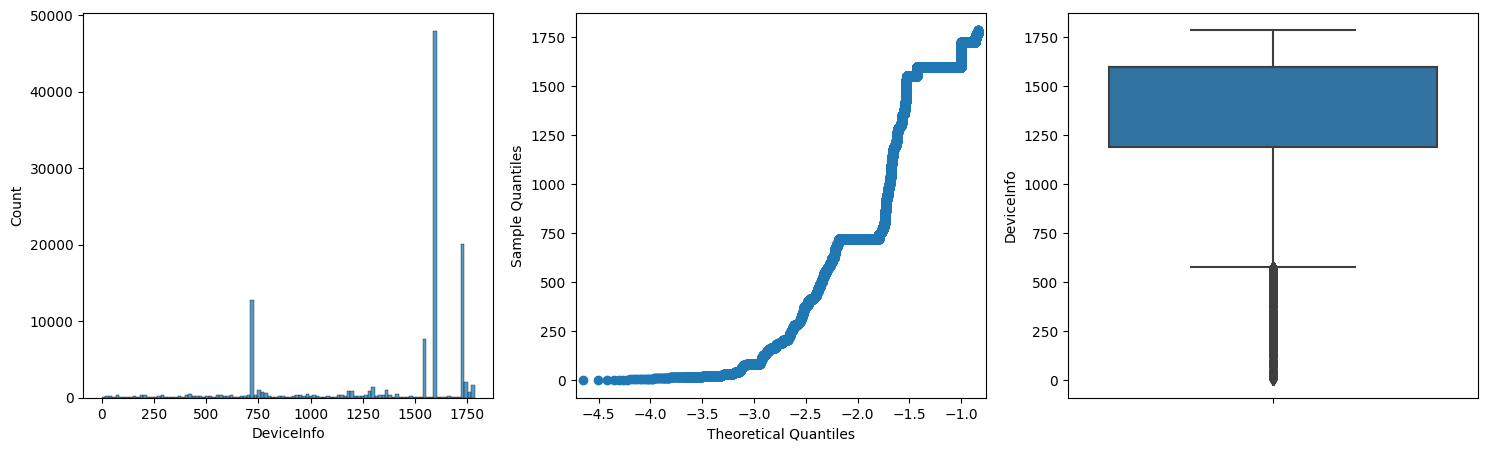

In [31]:
Outlier_Detect_IQR(train_df, 'DeviceInfo')

these features which need encode firstly cann't confirm which part values are Outliers.

So, these extreme values can be handled as rare value 

## addr1
this feature may be some address of user 

In [32]:
#values of addr1 are integer type
#so we detect Outliers firstly
train_df['addr1'].value_counts(normalize=True)

299.0    0.088285
325.0    0.081456
204.0    0.080063
264.0    0.075967
330.0    0.050086
           ...   
462.0    0.000002
128.0    0.000002
481.0    0.000002
120.0    0.000002
340.0    0.000002
Name: addr1, Length: 332, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 488.0
1.2 the potential outliers above 1.5IQR amount is : 20576
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
512.0            8268
494.0            5065
498.0            4744
492.0             987
502.0             835
536.0             309
511.0             157
508.0              70
499.0              26
520.0              26
504.0              10
491.0               7
529.0               7
496.0               7
540.0               6
521.0               6
527.0               4
501.0               4
507.0               4
514.0               3
523.0               3
509.0               3
528.0               2
517.0               2
535.0               2
518.0               2
513.0               2
515.0               2
500.0               2
531.0               1
493.0               1
530.0               1
522.0               1
526.0               1
503.0               1
516.0             

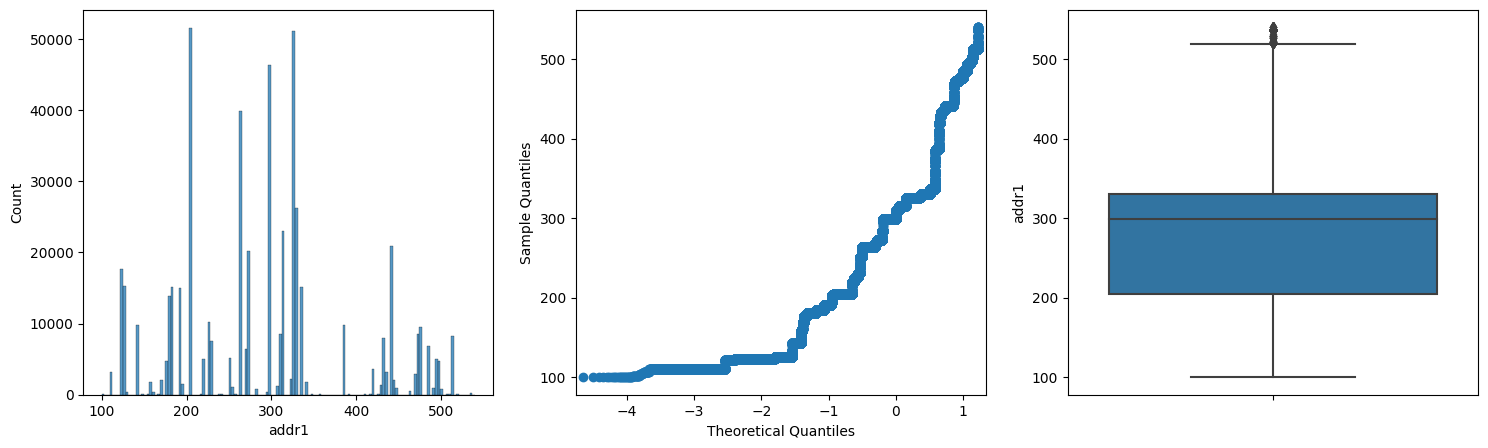

In [33]:
#addr1 拥有实数取值，因此可以直接的做异常值检测和处理
Outlier_Detect_IQR(train_df, 'addr1')

In [34]:
#handle Outliers with discretization
train_df['addr1'] = Outliers_Handle_Discretization(data = train_df, col = 'addr1',method = 'median')

## addr2

In [35]:
train_df['addr2'].value_counts(normalize=True)

87.0    0.991706
60.0    0.005876
96.0    0.001216
32.0    0.000173
65.0    0.000156
          ...   
55.0    0.000002
79.0    0.000002
49.0    0.000002
50.0    0.000002
70.0    0.000002
Name: addr2, Length: 74, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 87.0
1.2 the potential outliers above 1.5IQR amount is : 678
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
96.0             638
102.0             11
98.0              11
88.0               5
101.0              4
100.0              2
97.0               2
92.0               2
94.0               1
93.0               1
89.0               1
dtype: int64
1.4 the lower bound value is 87.0
1.5 the potential outliers below 1.5IQR amount is : 3675
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
60.0             3084
32.0               91
65.0               82
16.0               55
31.0               47
                 ... 
50.0                1
55.0                1
35.0                1
84.0                1
70.0                1
Length: 62, dtype: int64
----------------------------------------------------------------------------------------------------
2. when 

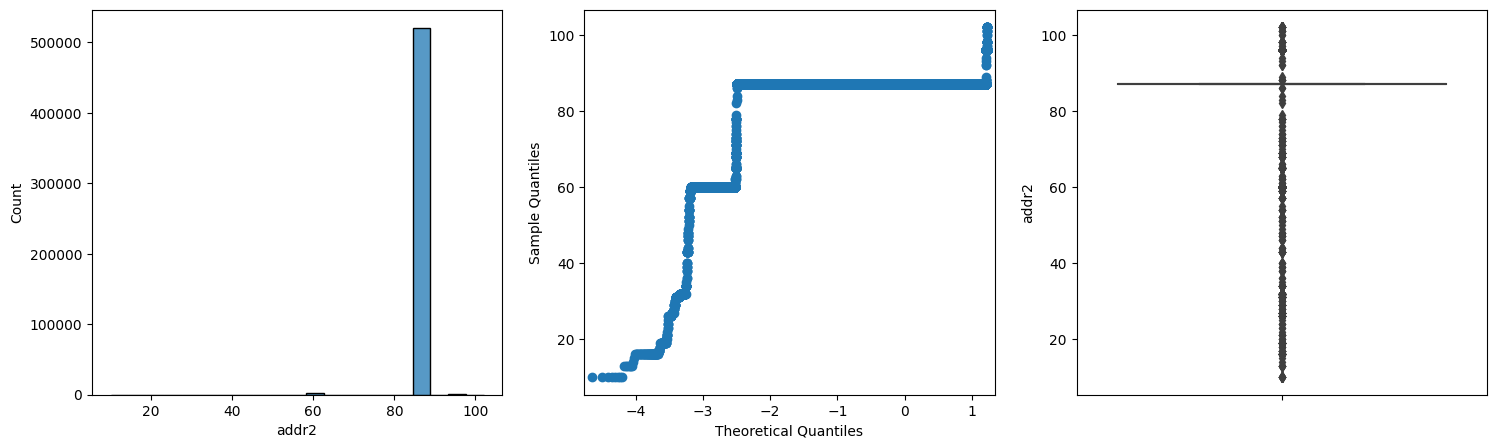

In [36]:
Outlier_Detect_IQR(train_df, 'addr2')

In [37]:
train_df['addr2'] = Outliers_Handle_Discretization(train_df, 'addr2', method = 'median')

## card1

In [38]:
train_df['card1'].value_counts(normalize=True)

7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
           ...   
12390    0.000002
10341    0.000002
10006    0.000002
15743    0.000002
17105    0.000002
Name: card1, Length: 13553, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 21925.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -2569.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 22146.234658109526
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -2348.765341890474
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


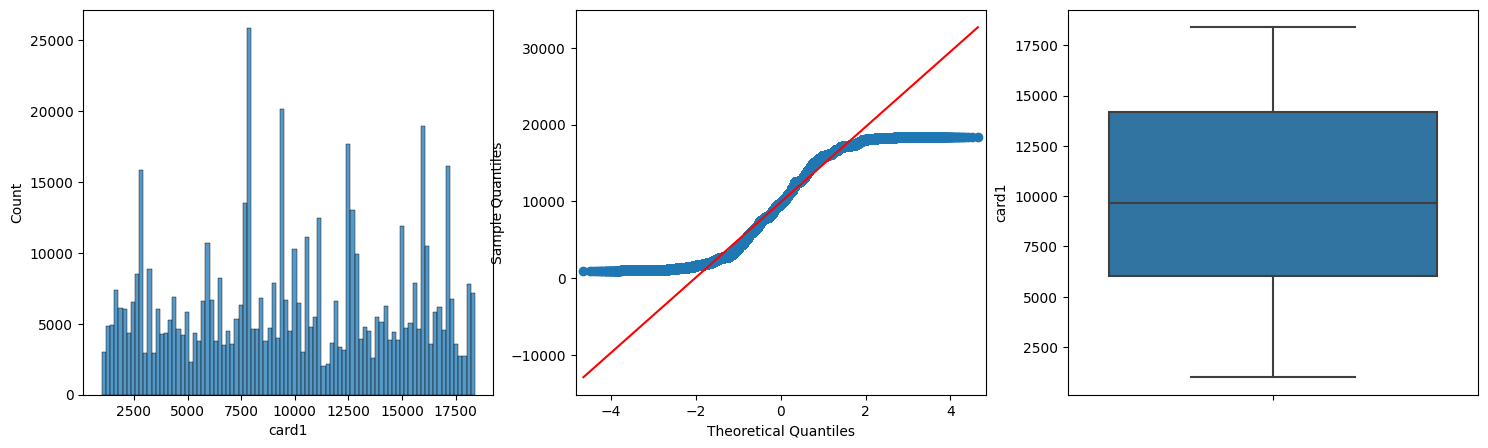

In [39]:
Outlier_Detect_IQR(train_df, 'card1')

- From this images above, we can confirm that feature 'card1' is uniform distribution. 

- Because its Q-Q shape is 's', we can confirm its variance is less than theorical expanded variance.

- The most important point is that there is no outliers in feature 'card1' for the reason of uniform distribution



## card2

In [40]:
train_df['card2'].value_counts(normalize= True)

321.0    0.084138
111.0    0.077700
555.0    0.072205
490.0    0.065586
583.0    0.037488
           ...   
447.0    0.000067
153.0    0.000065
557.0    0.000064
473.0    0.000031
582.0    0.000024
Name: card2, Length: 500, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 808.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -86.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 809.5554884999665
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -84.44451150003351
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


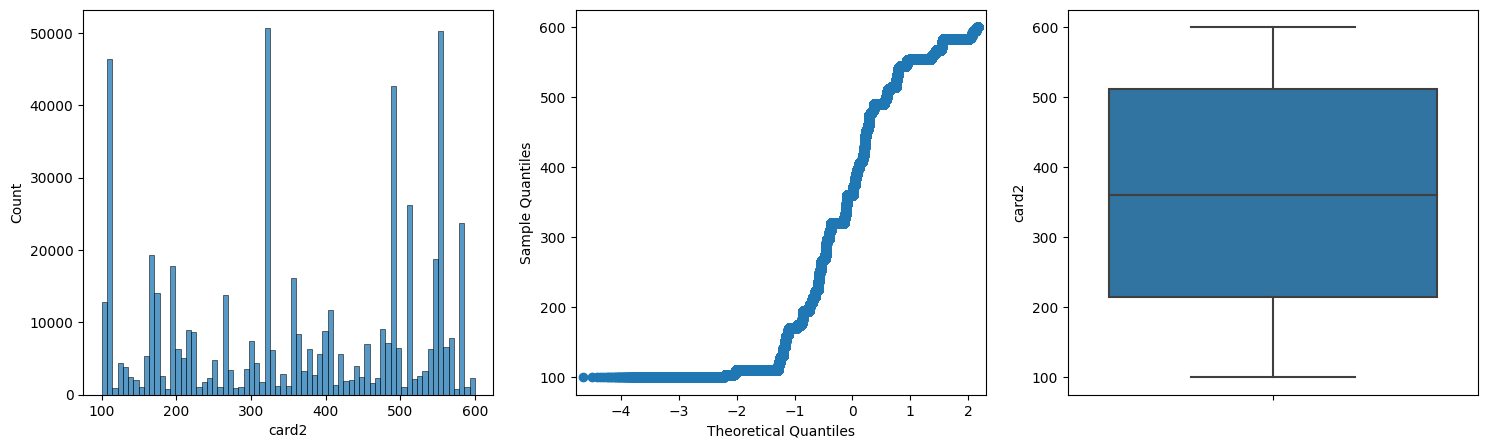

In [41]:
Outlier_Detect_IQR(train_df, col = 'card2')

- The feature 'card2' is approximate  uniform distribution.  
- The shape of Q-Q plot is like 's'
- There is also no outliers which are detected by IQR method

## card3

In [42]:
train_df['card3'].value_counts(normalize=True)

150.0    0.885075
185.0    0.095668
106.0    0.002667
146.0    0.002126
144.0    0.002126
           ...   
228.0    0.000002
139.0    0.000002
114.0    0.000002
164.0    0.000002
221.0    0.000002
Name: card3, Length: 114, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 150.0
1.2 the potential outliers above 1.5IQR amount is : 58738
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
185.0            56346
162.0              339
203.0              253
213.0              221
200.0              184
                 ...  
173.0                1
201.0                1
199.0                1
228.0                1
175.0                1
Length: 71, dtype: int64
1.4 the lower bound value is 150.0
1.5 the potential outliers below 1.5IQR amount is : 8950
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
106.0            1571
146.0            1252
144.0            1252
117.0             962
143.0             899
119.0             750
102.0             460
147.0             390
100.0             202
131.0             172
134.0             166
149.0             127
135.0             120
121.0              99
137.0              71
138.0   

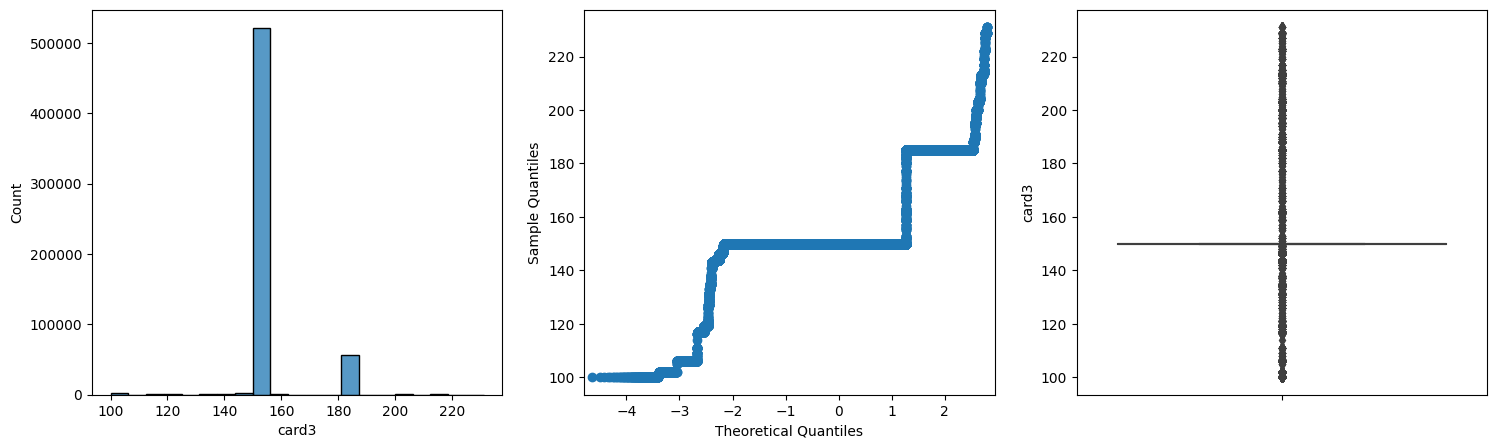

In [43]:
Outlier_Detect_IQR(data = train_df, col = 'card3')

According to IQR methon, if we discretize outliers there will be only a value 150 left. 

So, we can't discretize outliers directly.

Obviously, we should handle this feature differently.

In [44]:
#values except for 150 and 185 are classified into other value 0
train_df['card3'] = train_df['card3'].apply(lambda x : x if x == 150 or x == 185 else 0)

In [45]:
train_df['card3'].value_counts()

150.0    521287
185.0     56346
0.0       12907
Name: card3, dtype: int64

## card4

In [46]:
train_df['card4'].value_counts(normalize=True)

visa                0.653296
mastercard          0.321271
american express    0.014140
discover            0.011293
Name: card4, dtype: float64

In [47]:
#encoding card4 with Labelencoder firstly
train_df['card4'] = Encoder_With_Label(train_df, col = 'card4')

In [48]:
#after encoding
train_df['card4'].value_counts(normalize = True)

4.0    0.653296
2.0    0.321271
0.0    0.014140
1.0    0.011293
Name: card4, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 7.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 8328
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              8328
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 6.267018556594849
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 0.26701855659484863
2.5 the potential outliers below 1.5IQR amount is : 8328
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              8328
dtype: int64


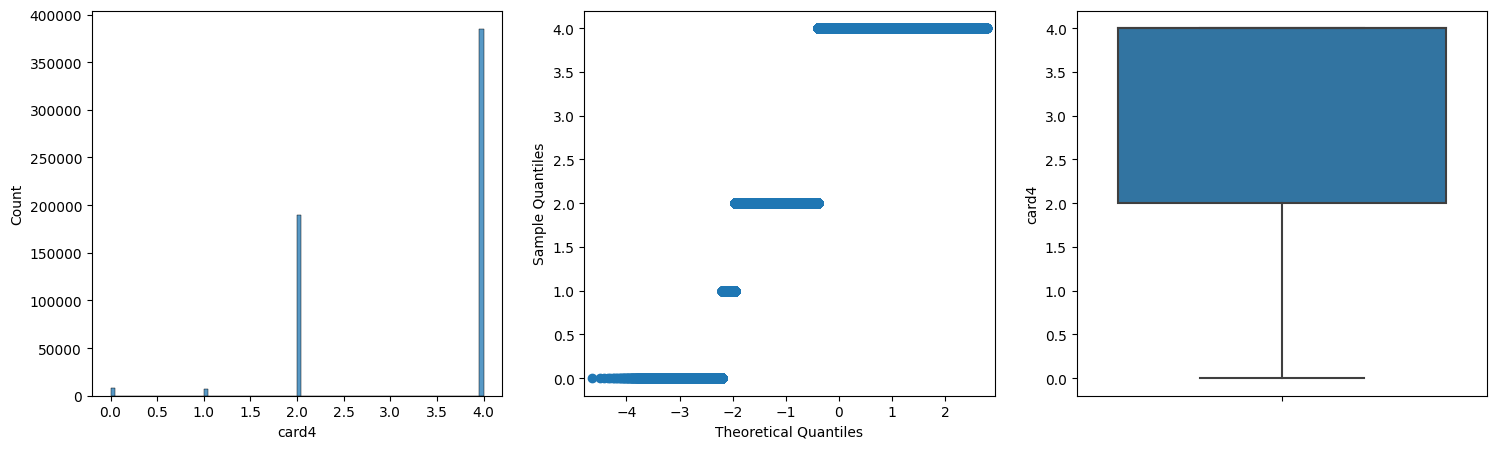

In [49]:
Outlier_Detect_IQR(data = train_df, col = 'card4')

Although IQR method doesn't detect outliers '1',  the percentage of 1 and 0 are both less.

So, it's necessary to check wheather there exist fraud sample which have card4 value if 0 and 1

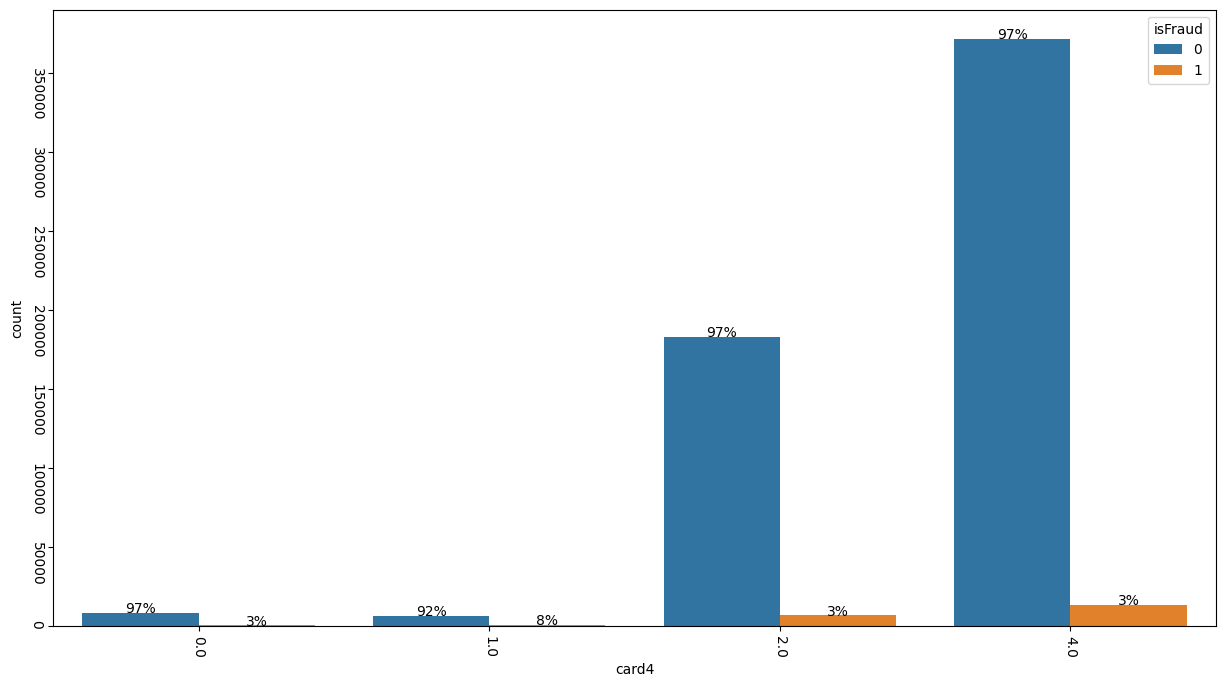

In [50]:
Plot_Cate_Correlation(data = train_df, col_A = 'card4', hue_B='isFraud', is_percentage=True)

after showing the percentage of 'isFraud' in 'card4'，we can find that fraud rate is high when card4 value is 1. But fraud rate is same when card4 is other values 

so, we modify card4 value 0 to 4 or 2

In [51]:
#modify card4 value 0 to 4
train_df['card4'] = train_df['card4'].apply(lambda x : 4 if x == 0 else x)

## card5

In [52]:
train_df['card5'].value_counts(normalize=True)

226.0    0.505809
224.0    0.139034
166.0    0.097462
102.0    0.049643
117.0    0.044247
           ...   
175.0    0.000002
173.0    0.000002
167.0    0.000002
234.0    0.000002
204.0    0.000002
Name: card5, Length: 119, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 316.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 136.0
1.5 the potential outliers below 1.5IQR amount is : 68613
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
102.0            29105
117.0            25941
126.0            10298
100.0              978
118.0              752
129.0              325
119.0              219
131.0              205
132.0              203
135.0              196
133.0              145
134.0               94
127.0               25
111.0               25
104.0               23
107.0               12
130.0               12
121.0               12
101.0                7
122.0                5
106.0                5
116.0                5
114.0                3
112.0                3
109.0                3
128.0                3
113.0     

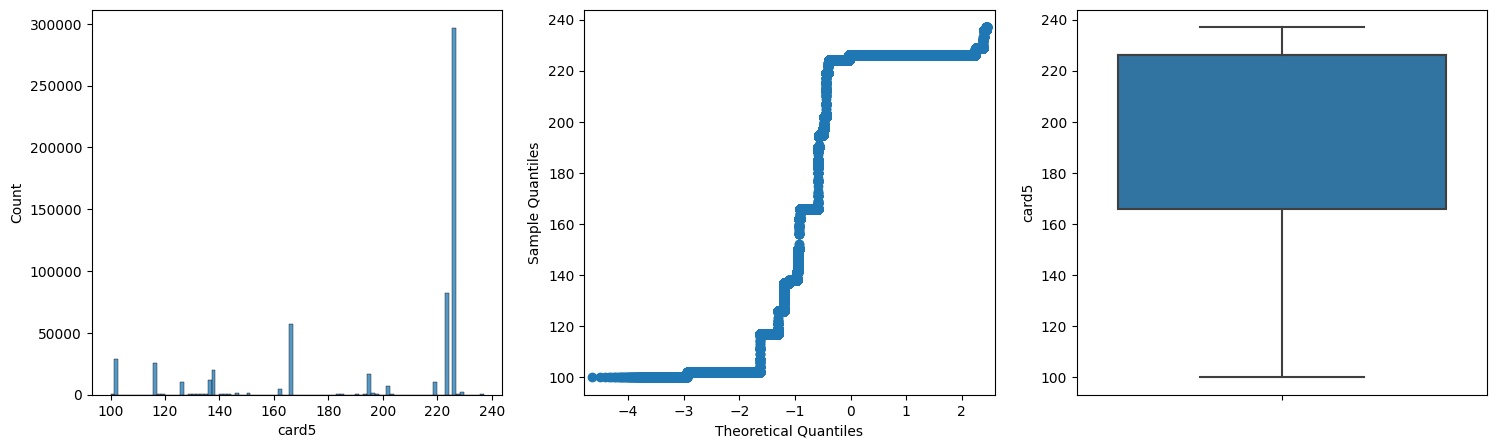

In [53]:
Outlier_Detect_IQR(data = train_df, col ='card5')

In [54]:
#discretize feature card5 outliers with value -9999
train_df['card5'] = Outliers_Handle_Discretization(data = train_df, col ='card5', method='median',value = -9999)

## card6

In [55]:
train_df['card6'].value_counts(normalize = True)

debit              0.746963
credit             0.252961
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64

In [56]:
train_df['card6'].value_counts(normalize=True)

debit              0.746963
credit             0.252961
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64

In [57]:
#encoding card6 firstly
train_df['card6'] = Encoder_With_Label(data = train_df, col = 'card6')

1. when median as the foundment value

1.1 the upper bound value is 3.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 0.5
1.5 the potential outliers below 1.5IQR amount is : 15
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              15
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 3.247039318084717
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 0.2470393180847168
2.5 the potential outliers below 1.5IQR amount is : 15
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              15
dtype: int64


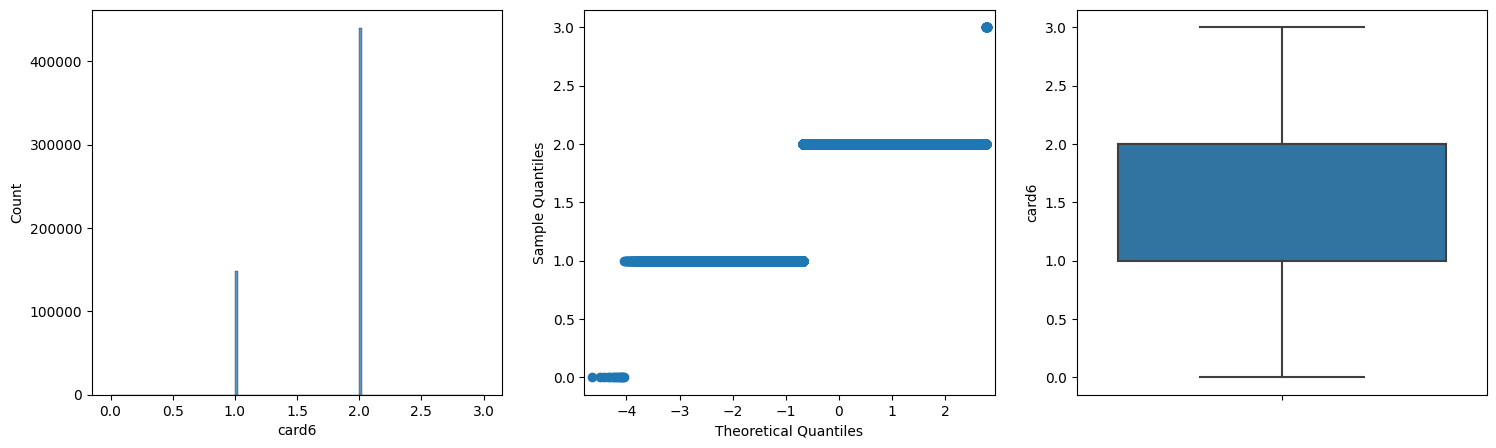

In [58]:
Outlier_Detect_IQR(data = train_df, col = 'card6')

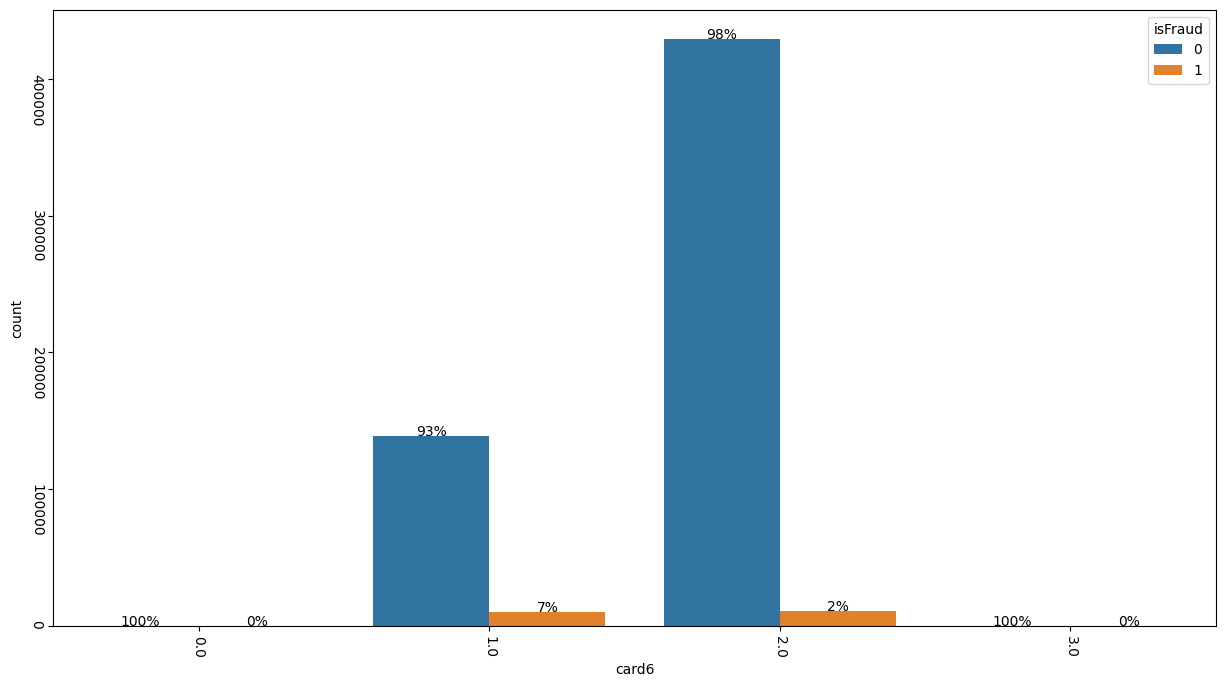

In [59]:
Plot_Cate_Correlation(data = train_df, col_A='card6', hue_B='isFraud',is_percentage=True)

According to image above, we can find that there is no fraud samples  when card6 value is 0 or 3

Moreover, their percentages are small. So,we can modify card6 value 0 and 3 to 2

In [60]:
train_df['card6'] = train_df['card6'].apply(lambda x : 2 if x == 0 or x == 3 else x )

In [61]:
train_df['card6'].value_counts()

2.0    439983
1.0    148986
Name: card6, dtype: int64

## M1

In [62]:
train_df['M1'].value_counts(normalize=True)

T    0.999922
F    0.000078
Name: M1, dtype: float64

In [63]:
#there only two values in feature M1,so we take onehot encoder method to encode 'M1' directly

train_df['M1'] = Encoder_With_Label(data = train_df, col = 'M1')

In [64]:
train_df['M1'].value_counts(normalize = True)

1.0    0.999922
0.0    0.000078
Name: M1, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 25
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              25
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.9999217391014099
2.2 the potential outliers above 1.5IQR amount is : 319415
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              319415
dtype: int64
2.4 the lower bound is 0.9999217391014099
2.5 the potential outliers below 1.5IQR amount is : 25
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              25
dtype: int64


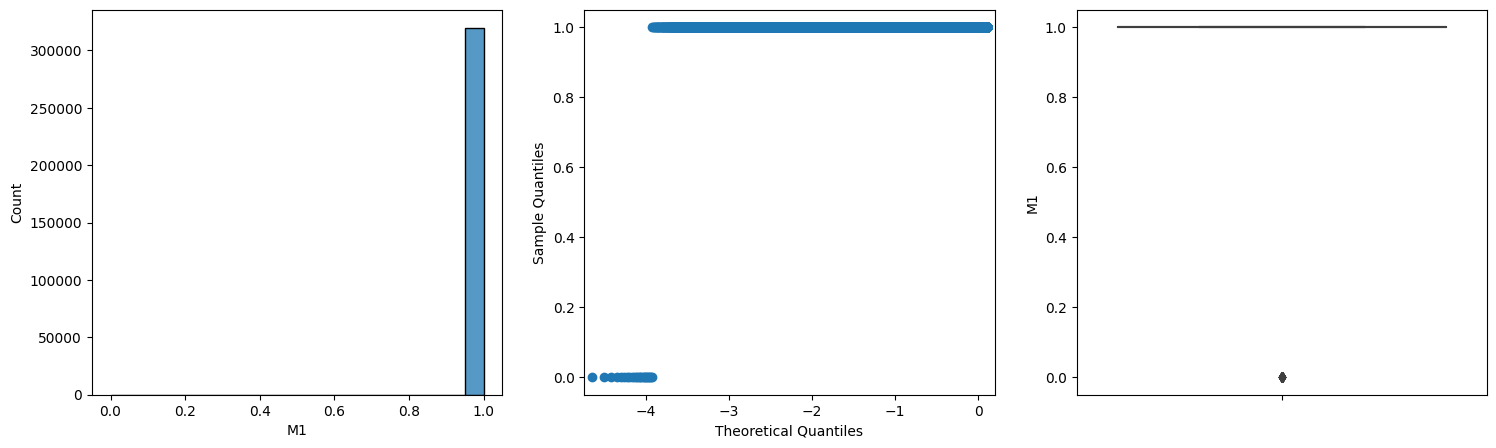

In [65]:
Outlier_Detect_IQR(data = train_df, col = 'M1')

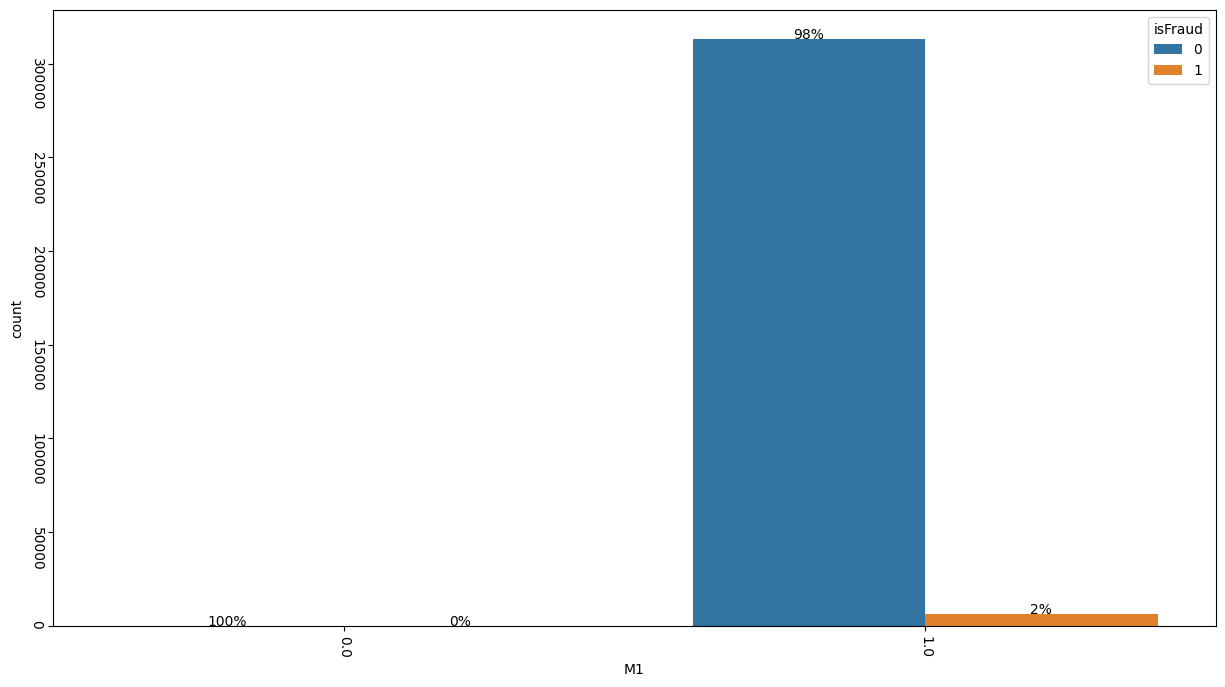

In [66]:
Plot_Cate_Correlation(data = train_df, col_A='M1', hue_B='isFraud', is_percentage=True)

According to images above, we can sure that M1 with value 0 has no fraud samples, so we can delete it directly. 

Because M1 takes a small percentage when its value is 0. If we modify its value to 1, M1 has only a value which has no effect on model. 

In [67]:
train_df.drop(labels = ['M1'], axis = 1, inplace = True)

## M2

In [68]:
train_df['M2'].value_counts(normalize=True)

T    0.893651
F    0.106349
Name: M2, dtype: float64

In [69]:
#Encoding M2 firstly
train_df['M2'] = Encoder_With_Label(data = train_df, col = 'M2')

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 33972
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              33972
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.8936513662338257
2.2 the potential outliers above 1.5IQR amount is : 285468
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              285468
dtype: int64
2.4 the lower bound is 0.8936513662338257
2.5 the potential outliers below 1.5IQR amount is : 33972
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              33972
dtype: int6

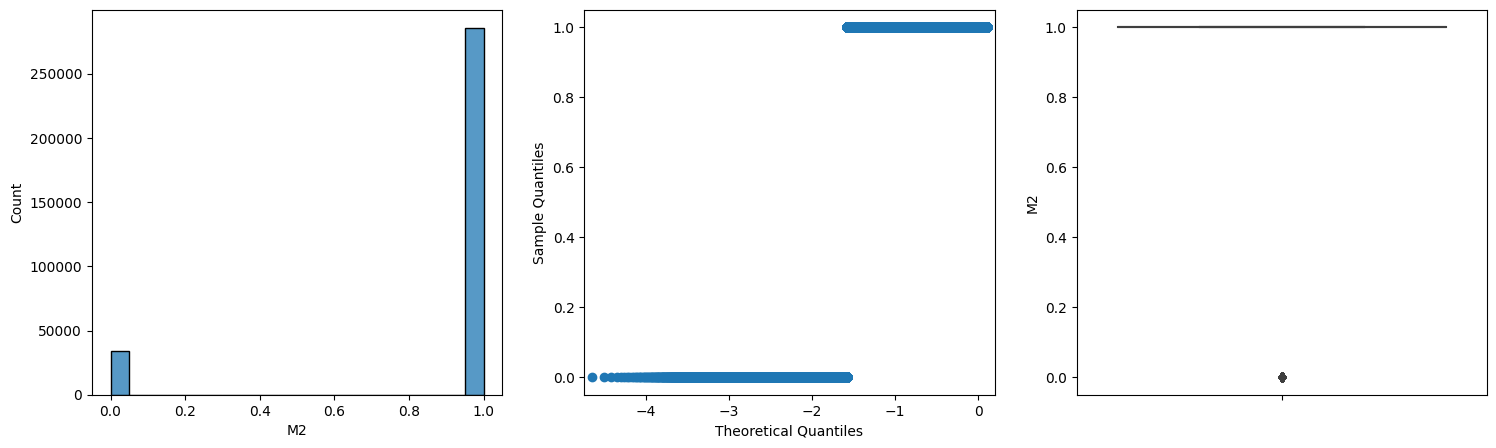

In [70]:
Outlier_Detect_IQR(data = train_df, col= 'M2')

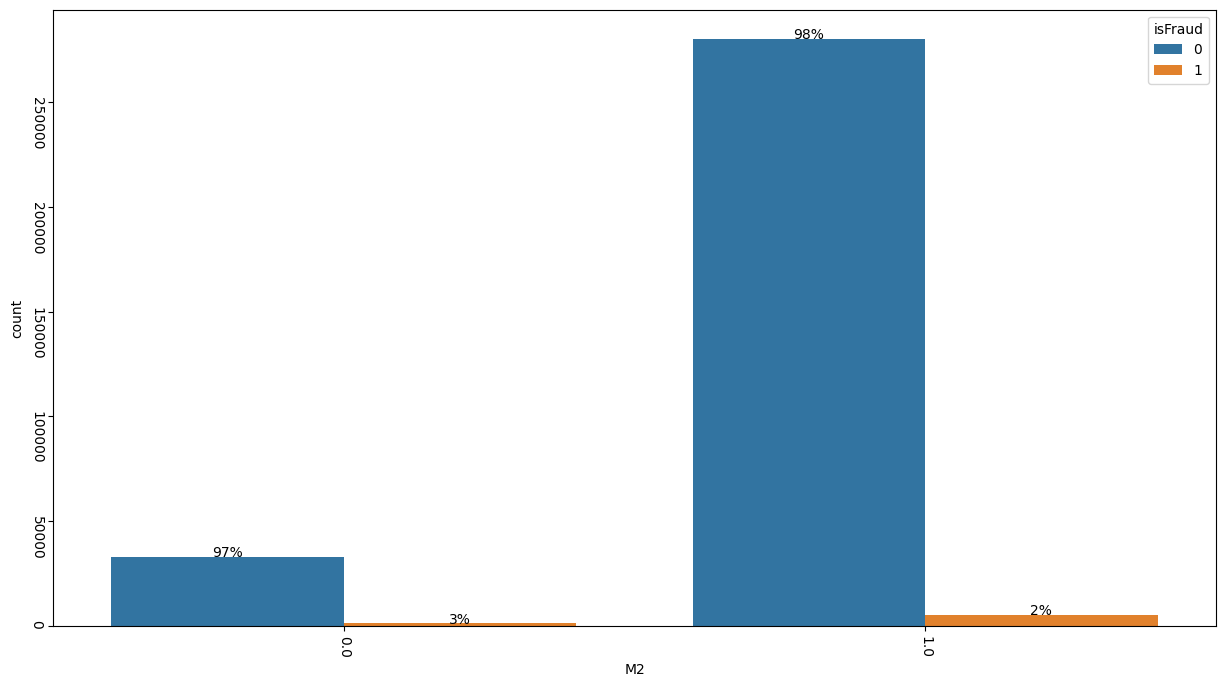

In [71]:
Plot_Cate_Correlation(data = train_df, col_A= 'M2', hue_B='isFraud', is_percentage=True)

Although the percentage of M2 is small when value is 0, the Fraud sample has a 3% percentage. so,we 
can't handle outlier 0 according to IQR method.

we just encode it whit labelencoder.

## M3

In [73]:
train_df['M3'].value_counts(normalize=True)

T    0.788038
F    0.211962
Name: M3, dtype: float64

In [74]:
#encode M3 firstly
train_df['M3']  = Encoder_With_Label(data = train_df, col = 'M3')

In [75]:
train_df['M3'].value_counts(normalize=True)

1.0    0.788038
0.0    0.211962
Name: M3, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 67709
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              67709
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.788038432598114
2.2 the potential outliers above 1.5IQR amount is : 251731
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              251731
dtype: int64
2.4 the lower bound is 0.788038432598114
2.5 the potential outliers below 1.5IQR amount is : 67709
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              67709
dtype: int64


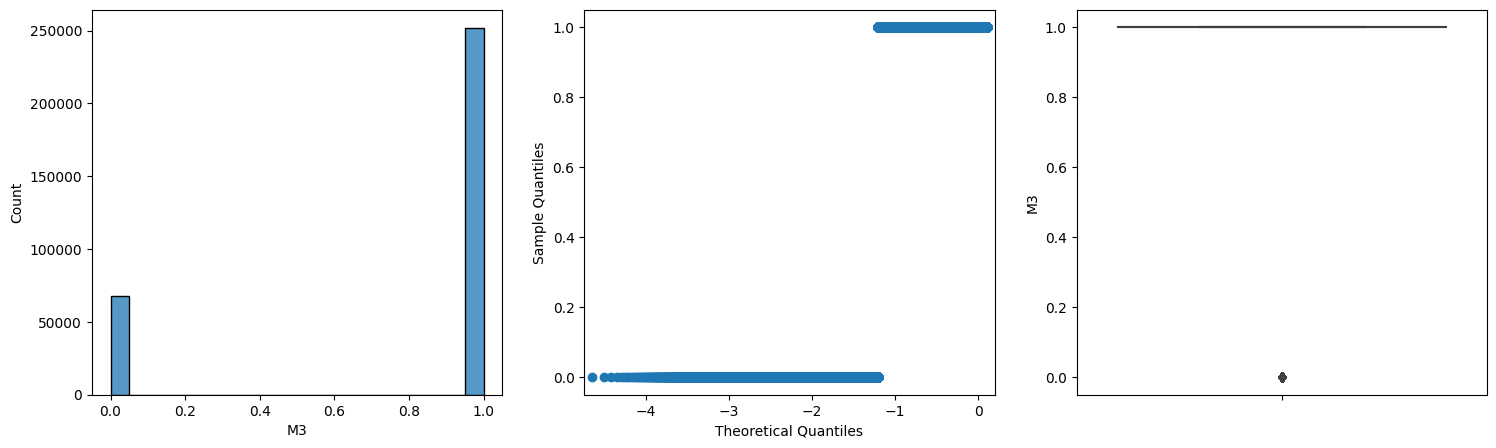

In [76]:
Outlier_Detect_IQR(data = train_df, col='M3')

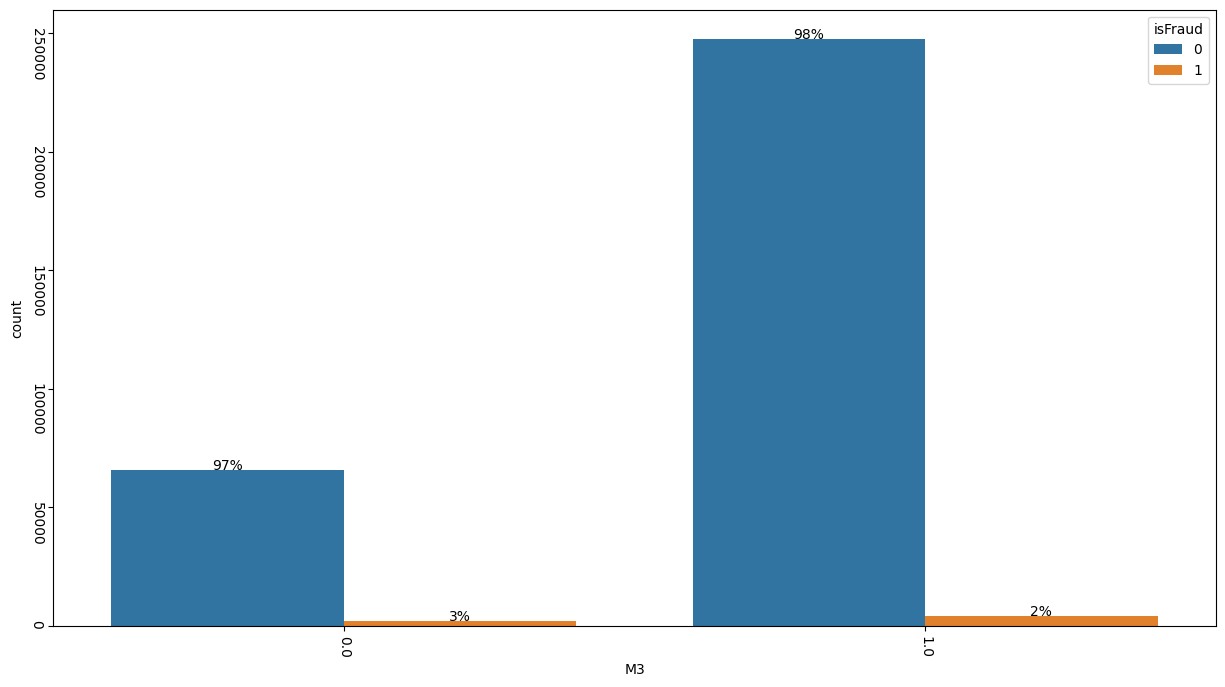

In [78]:
Plot_Cate_Correlation(data = train_df, col_A='M3', hue_B='isFraud', is_percentage=True)

just encoding,there is nothing  necessary to do

## M4

In [79]:
train_df['M4'].value_counts(normalize=True)

M0    0.635417
M2    0.193678
M1    0.170905
Name: M4, dtype: float64

M4 has a relatively uniform proportion, so  we just need to encode M4

In [80]:
#encode M4 with labelencoder
train_df['M4'] = Encoder_With_Label(data = train_df, col= 'M4')

## M5

In [81]:
train_df['M5'].value_counts(normalize=True)

F    0.551912
T    0.448088
Name: M5, dtype: float64

In [82]:
#encode M5 with labelecoder
train_df['M5'] = Encoder_With_Label(data = train_df, col='M5')

## M6

In [83]:
train_df['M6'].value_counts(normalize=True)

F    0.540994
T    0.459006
Name: M6, dtype: float64

In [84]:
#encode M6 with labelencoder
train_df['M6'] = Encoder_With_Label(data = train_df, col = 'M6')

## M7

In [85]:
train_df['M7'].value_counts(normalize=True)

F    0.865312
T    0.134688
Name: M7, dtype: float64

In [86]:
#encode M7 with labelencoder
train_df['M7'] = Encoder_With_Label(data = train_df, col = 'M7')

## M8

In [87]:
train_df['M8'].value_counts(normalize=True)

F    0.635524
T    0.364476
Name: M8, dtype: float64

In [88]:
#encode  m7 with labelencoder
train_df['M8'] = Encoder_With_Label(data = train_df, col='M8')

## M9

In [89]:
train_df['M9'].value_counts(normalize=True)

T    0.841859
F    0.158141
Name: M9, dtype: float64

In [90]:
#encode M9 with labelencoder
train_df['M9'] = Encoder_With_Label(data = train_df, col = 'M9')

## id_12

In [91]:
train_df['id_12'].value_counts(normalize=True)

NotFound    0.85296
Found       0.14704
Name: id_12, dtype: float64

In [92]:
#encoder id_12 with labelencoder 
train_df['id_12'] = Encoder_With_Label(data = train_df, col = 'id_12')

1. when median as the foundment value

1.1 the upper bound value is 1.0
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 1.0
1.5 the potential outliers below 1.5IQR amount is : 21208
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              21208
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 0.8529601693153381
2.2 the potential outliers above 1.5IQR amount is : 123025
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
1.0              123025
dtype: int64
2.4 the lower bound is 0.8529601693153381
2.5 the potential outliers below 1.5IQR amount is : 21208
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              21208
dtype: int6

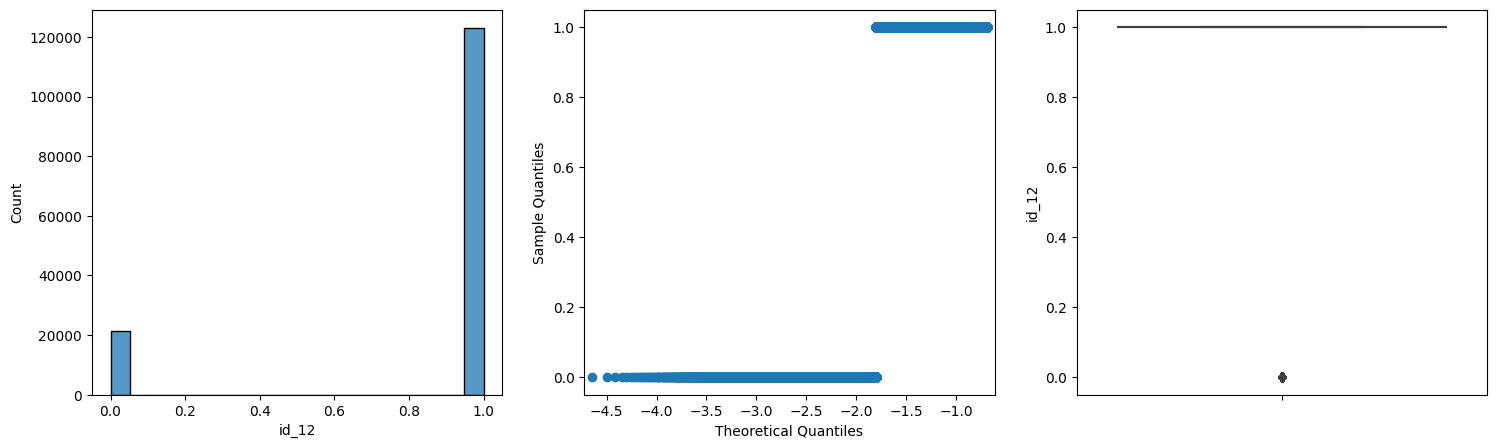

In [93]:
Outlier_Detect_IQR(data = train_df, col = 'id_12')

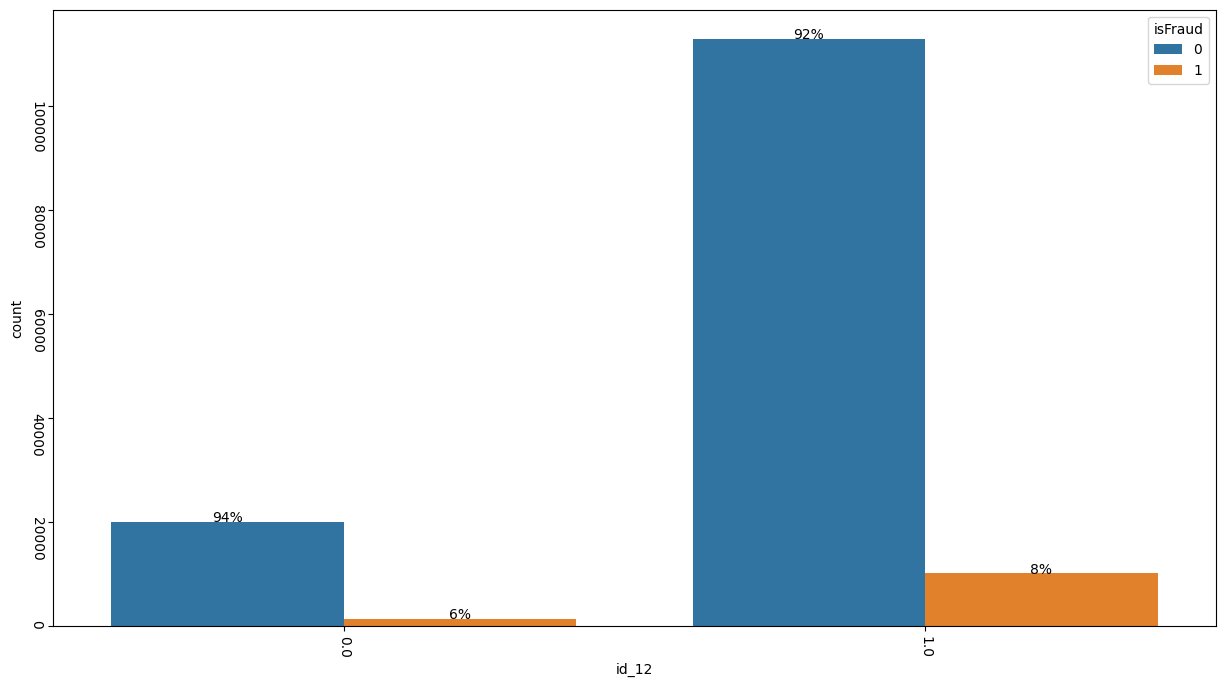

In [94]:
Plot_Cate_Correlation(data = train_df, col_A='id_12', hue_B='isFraud', is_percentage=True)

According to correlation image, we can confirm that id_12 has fraud sample when its value is 0 or 1.

so, we just need to encode id_12

## ID_13

In [95]:
train_df['id_13'].value_counts(normalize=True)

52.0    0.456323
49.0    0.207077
64.0    0.113329
33.0    0.078919
27.0    0.028794
20.0    0.022604
14.0    0.019628
63.0    0.011530
19.0    0.009009
25.0    0.008373
43.0    0.006613
62.0    0.006385
18.0    0.005404
41.0    0.005137
55.0    0.004108
11.0    0.002930
15.0    0.002922
24.0    0.002498
35.0    0.002490
51.0    0.001539
61.0    0.000848
44.0    0.000668
54.0    0.000526
28.0    0.000463
39.0    0.000267
31.0    0.000228
45.0    0.000204
38.0    0.000173
13.0    0.000165
58.0    0.000134
36.0    0.000118
48.0    0.000079
32.0    0.000079
56.0    0.000071
30.0    0.000055
22.0    0.000039
53.0    0.000031
17.0    0.000024
21.0    0.000024
57.0    0.000024
46.0    0.000024
47.0    0.000024
60.0    0.000024
12.0    0.000016
26.0    0.000016
59.0    0.000008
50.0    0.000008
10.0    0.000008
23.0    0.000008
37.0    0.000008
29.0    0.000008
34.0    0.000008
40.0    0.000008
42.0    0.000008
Name: id_13, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 56.5
1.2 the potential outliers above 1.5IQR amount is : 16842
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
64.0             14429
63.0              1468
62.0               813
61.0               108
58.0                17
60.0                 3
57.0                 3
59.0                 1
dtype: int64
1.4 the lower bound value is 47.5
1.5 the potential outliers below 1.5IQR amount is : 25204
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
33.0             10048
27.0              3666
20.0              2878
14.0              2499
19.0              1147
25.0              1066
43.0               842
18.0               688
41.0               654
11.0               373
15.0               372
24.0               318
35.0               317
44.0                85
28.0                59
39.0                34
31.0                29
45.0                26
38.0  

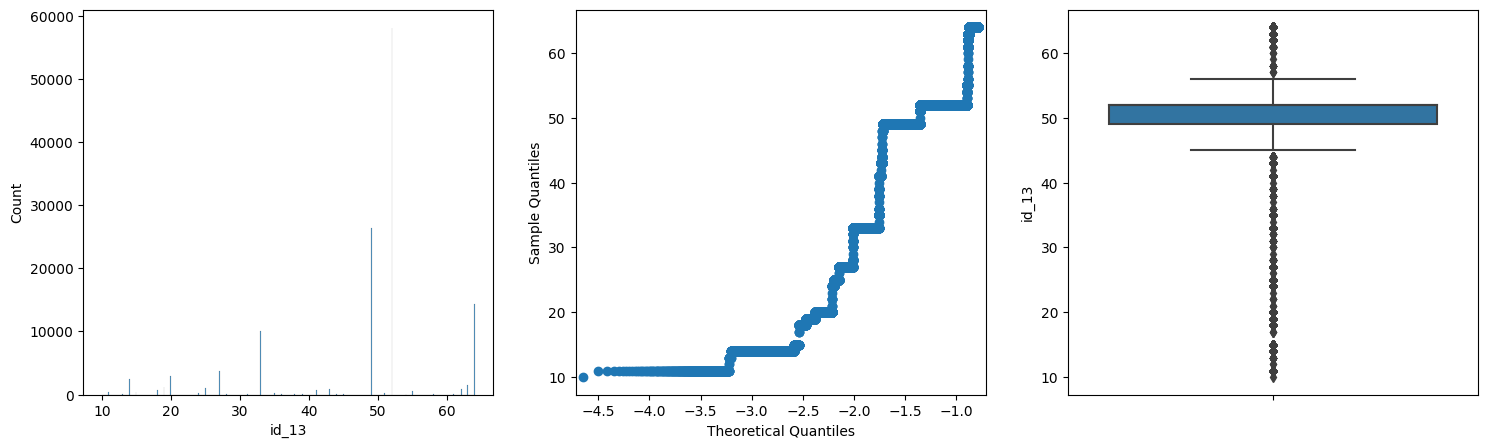

In [100]:
Outlier_Detect_IQR(data = train_df, col='id_13')

In [101]:
#diseretize outliers into other value 9999
train_df['id_13'] = Outliers_Handle_Discretization(data = train_df, col='id_13',method = 'median', value=9999)

## id_14

In [102]:
train_df['id_14'].value_counts(normalize=True)

-300.0    0.551209
-360.0    0.208148
-480.0    0.161049
-420.0    0.056744
-600.0    0.006222
 60.0     0.004610
 0.0      0.002399
-240.0    0.001986
-180.0    0.001574
-540.0    0.001387
 480.0    0.000999
 540.0    0.000800
 600.0    0.000775
 120.0    0.000512
 180.0    0.000462
 420.0    0.000237
 330.0    0.000212
 270.0    0.000187
 240.0    0.000162
 300.0    0.000150
 720.0    0.000112
-660.0    0.000025
-210.0    0.000012
 360.0    0.000012
-120.0    0.000012
Name: id_14, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is -210.0
1.2 the potential outliers above 1.5IQR amount is : 1058
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
 60.0            369
 0.0             192
-180.0           126
 480.0            80
 540.0            64
 600.0            62
 120.0            41
 180.0            37
 420.0            19
 330.0            17
 270.0            15
 240.0            13
 300.0            12
 720.0             9
 360.0             1
-120.0             1
dtype: int64
1.4 the lower bound value is -390.0
1.5 the potential outliers below 1.5IQR amount is : 18044
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
-480.0           12891
-420.0            4542
-600.0             498
-540.0             111
-660.0               2
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value


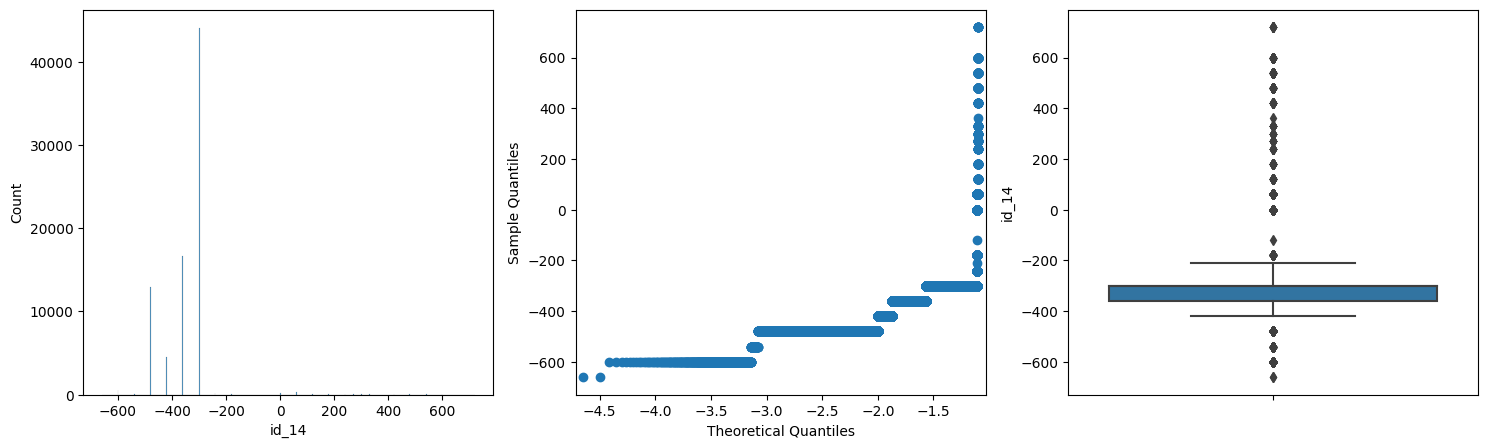

In [103]:
Outlier_Detect_IQR(data = train_df, col = 'id_14')

In [105]:
#discretize outliers into a single value box
train_df['id_14'] = Outliers_Handle_Discretization(data = train_df, col = 'id_14',value=999999)

## id_15

In [106]:
train_df['id_15'].value_counts(normalize=True)

Found      0.480392
New        0.437011
Unknown    0.082597
Name: id_15, dtype: float64

In [107]:
#encoding id_15 firstly
train_df['id_15'] = Encoder_With_Label(data = train_df, col='id_15')

In [108]:
train_df['id_15'].value_counts(normalize=True)

0.0    0.480392
1.0    0.437011
2.0    0.082597
Name: id_15, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 2.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -0.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 2.1022059321403503
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -0.8977940678596497
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


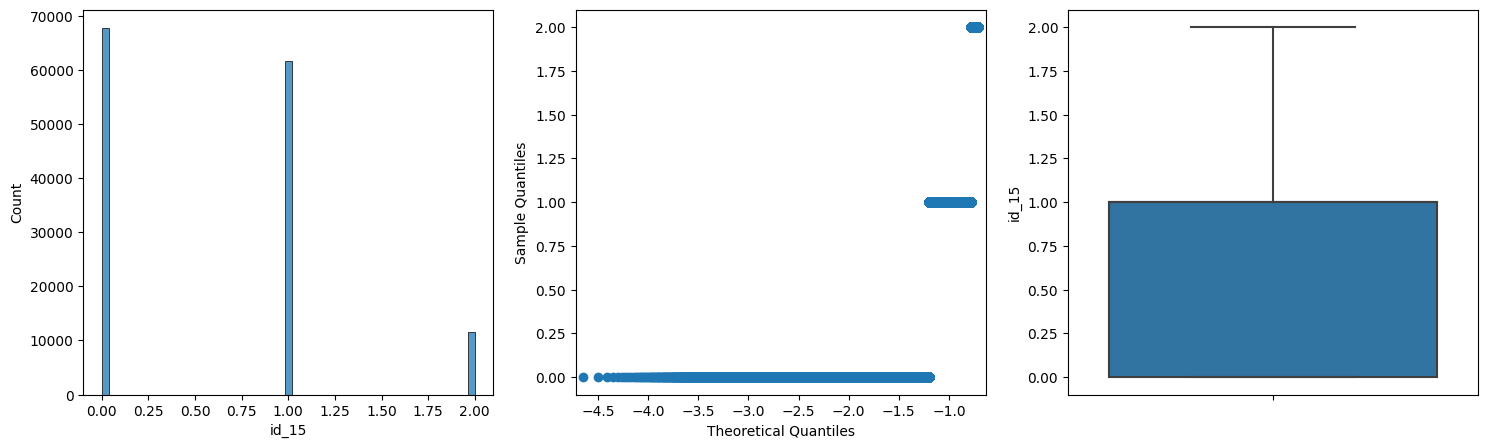

In [109]:
Outlier_Detect_IQR(data = train_df, col='id_15')

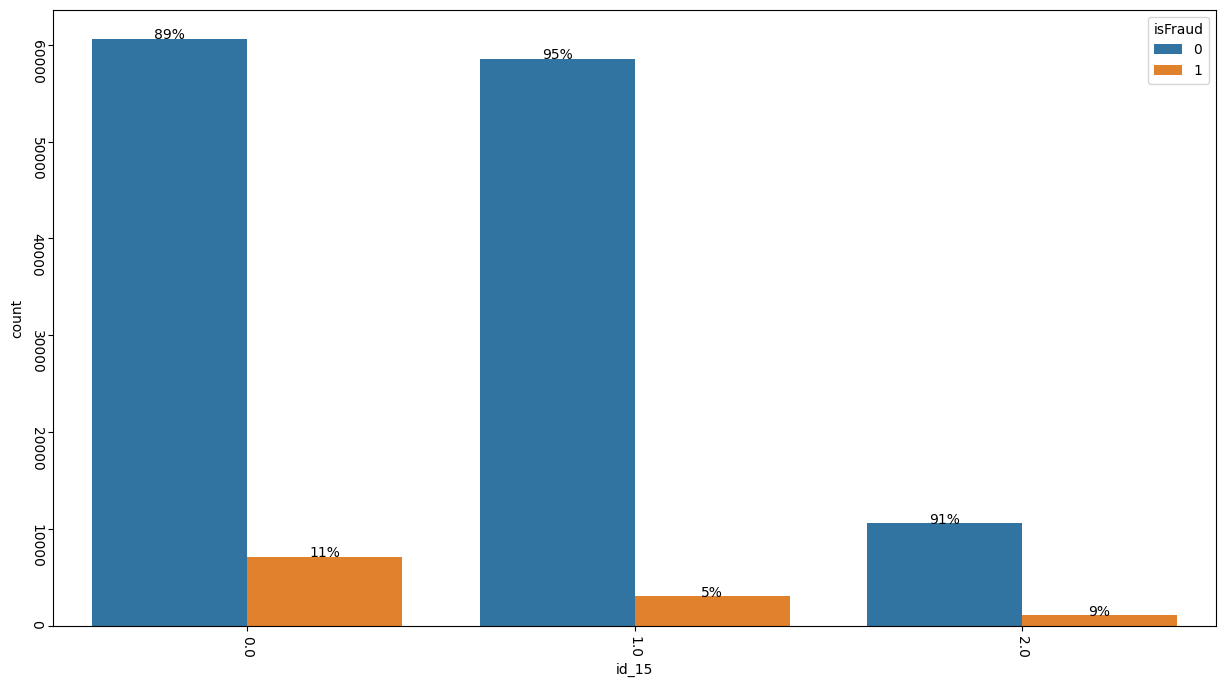

In [111]:
Plot_Cate_Correlation(data = train_df, col_A='id_15', hue_B='isFraud')

Sample has relatively high fraud rate when id_15 is 2. But the percentage of 2 is the minimum in id_15. 

For this reason, we can't process this feature outliers with discretization or other methods

## id_16

In [113]:
train_df['id_16'].value_counts(normalize=True)

Found       0.512788
NotFound    0.487212
Name: id_16, dtype: float64

In [114]:
#encoding id_16 firstly
train_df['id_16'] = Encoder_With_Label(data = train_df, col = 'id_16')

1. when median as the foundment value

1.1 the upper bound value is 1.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is -1.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 1.9872120022773743
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -1.0127879977226257
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


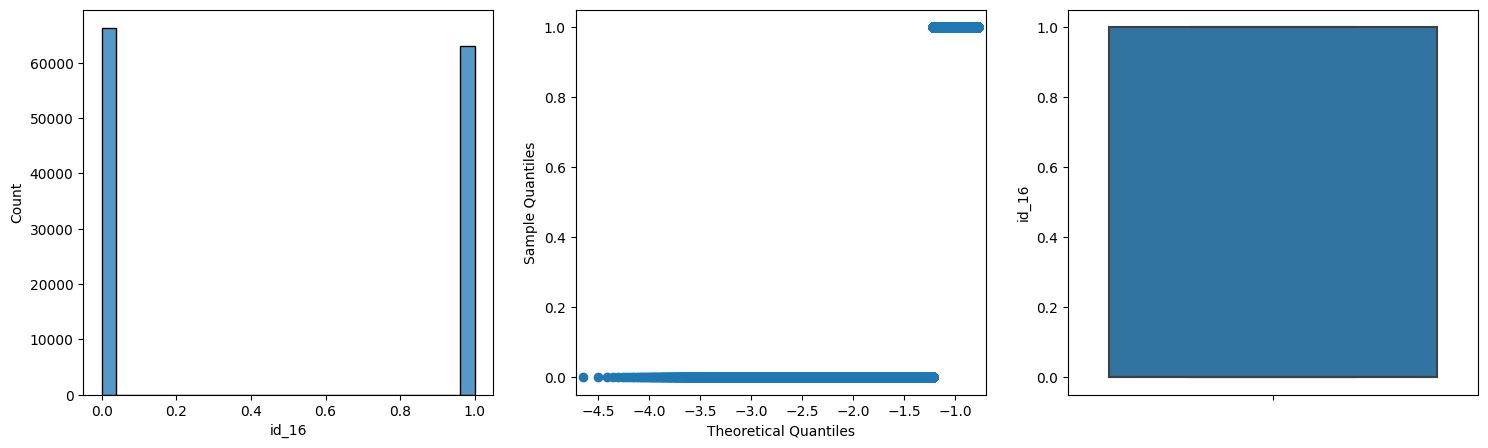

In [115]:
Outlier_Detect_IQR(data = train_df, col='id_16')

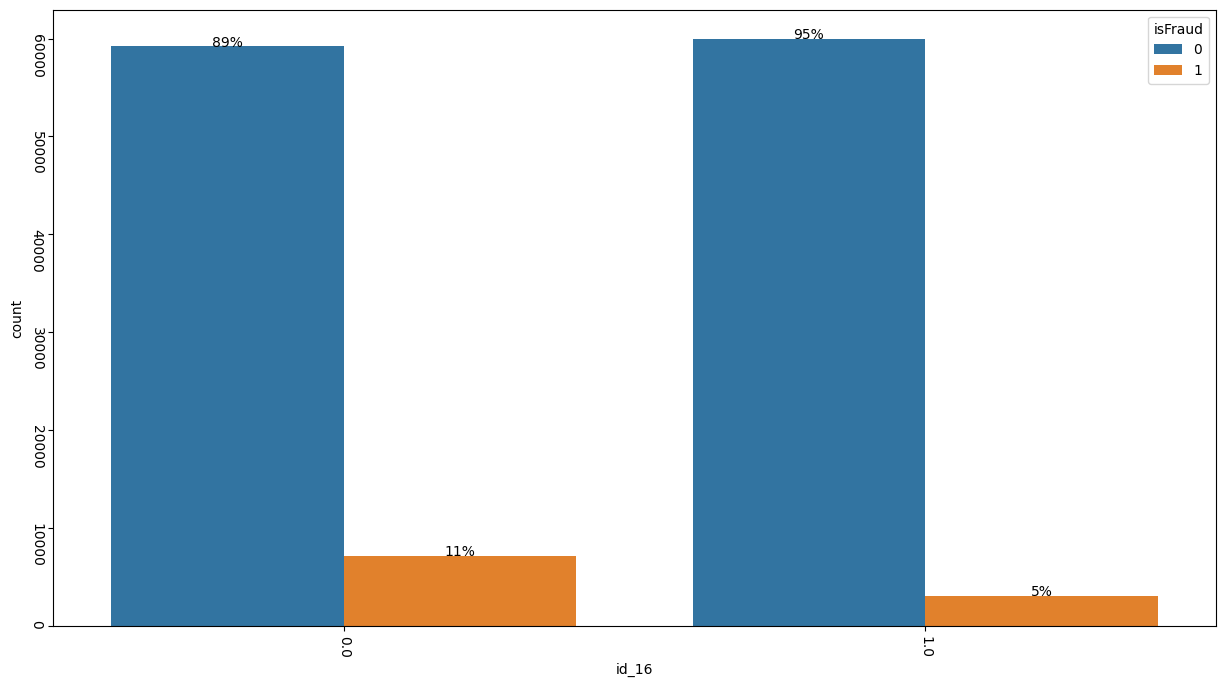

In [116]:
Plot_Cate_Correlation(train_df, col_A='id_16',hue_B='isFraud')

This feature is obviously needless to process by outliers methods

## id_17

In [117]:
train_df['id_17'].value_counts(normalize=True)

166.0    0.564193
225.0    0.408757
102.0    0.004944
159.0    0.002526
100.0    0.002411
           ...   
207.0    0.000007
173.0    0.000007
125.0    0.000007
175.0    0.000007
188.0    0.000007
Name: id_17, Length: 104, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 254.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 77.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 277.95137727902187
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is 100.95137727902187
2.5 the potential outliers below 1.5IQR amount is : 336
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
100.0            336
dtype: int64


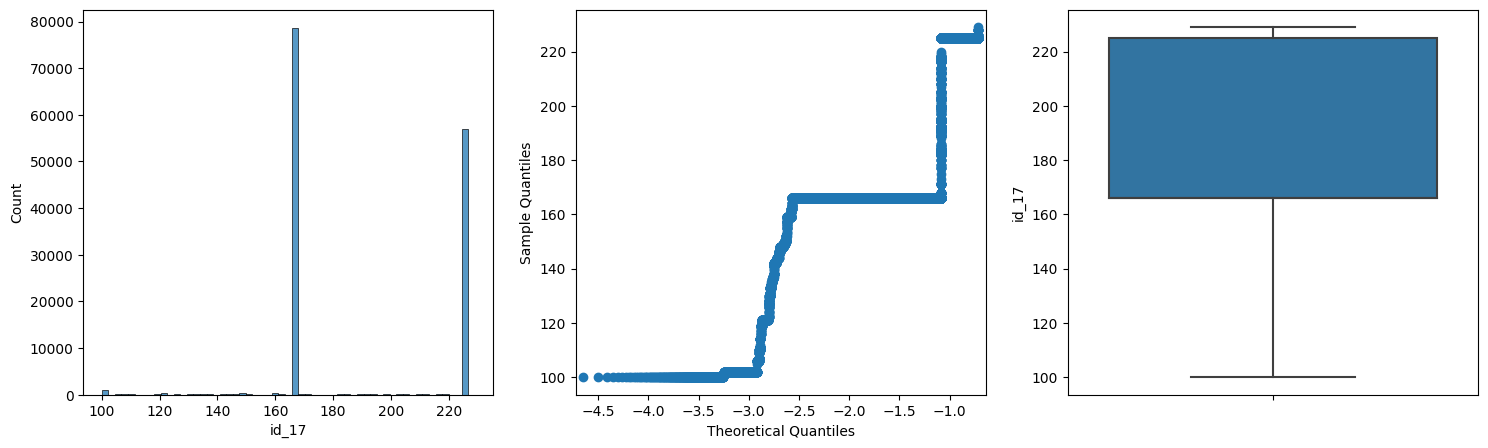

In [118]:
Outlier_Detect_IQR(train_df, col = 'id_17')

This feature may be processed by rare values method

## id_18

In [119]:
train_df['id_18'].value_counts(normalize=True)

15.0    0.565003
13.0    0.297896
12.0    0.103208
18.0    0.014408
20.0    0.007514
17.0    0.005165
26.0    0.001973
21.0    0.001729
24.0    0.001153
11.0    0.000798
27.0    0.000709
29.0    0.000199
23.0    0.000089
14.0    0.000066
16.0    0.000022
28.0    0.000022
25.0    0.000022
10.0    0.000022
Name: id_18, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 18.0
1.2 the potential outliers above 1.5IQR amount is : 605
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
20.0             339
26.0              89
21.0              78
24.0              52
27.0              32
29.0               9
23.0               4
28.0               1
25.0               1
dtype: int64
1.4 the lower bound value is 12.0
1.5 the potential outliers below 1.5IQR amount is : 37
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
11.0             36
10.0              1
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 17.23733735286946
2.2 the potential outliers above 1.5IQR amount is : 1255
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
18.0             650
20.0             339
26.

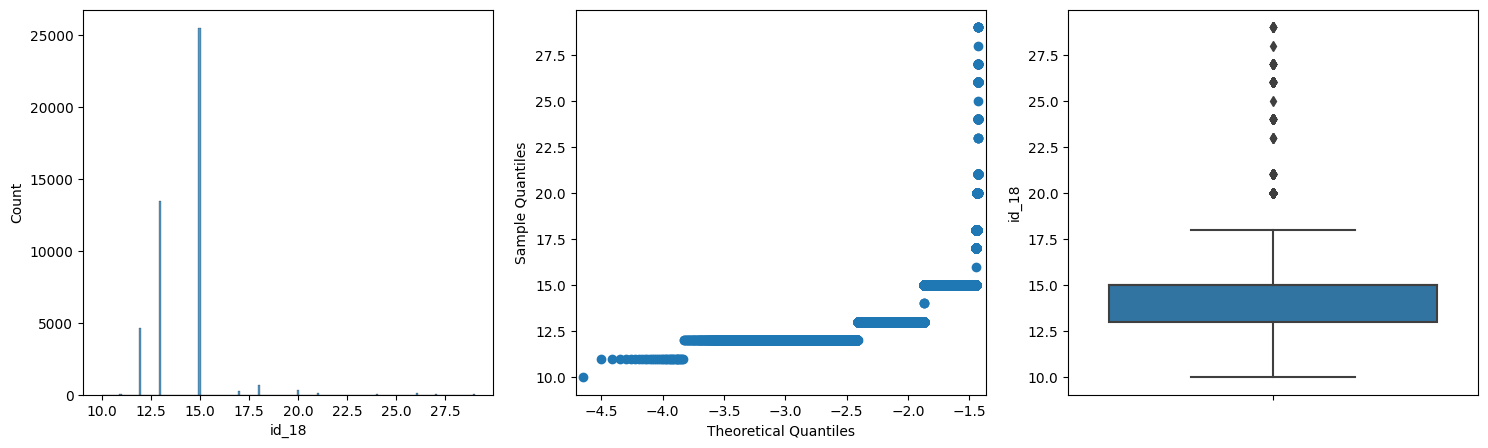

In [121]:
Outlier_Detect_IQR(train_df,col ='id_18')

In [122]:
train_df['id_18'] = Outliers_Handle_Discretization(data = train_df, col = 'id_18', value=999999)

## id_19

In [123]:
train_df['id_19'].value_counts(normalize=True)

266.0    0.142473
410.0    0.081239
427.0    0.063222
529.0    0.058298
312.0    0.044696
           ...   
425.0    0.000007
412.0    0.000007
135.0    0.000007
363.0    0.000007
428.0    0.000007
Name: id_19, Length: 522, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 582.5
1.2 the potential outliers above 1.5IQR amount is : 8319
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
633.0            2702
621.0            2153
607.0             709
630.0             371
585.0             272
                 ... 
589.0               1
619.0               1
668.0               1
584.0               1
604.0               1
Length: 83, dtype: int64
1.4 the lower bound value is 99.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 594.6281743923972
2.2 the potential outliers above 1.5IQR amount is : 7913
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
633.0            2702

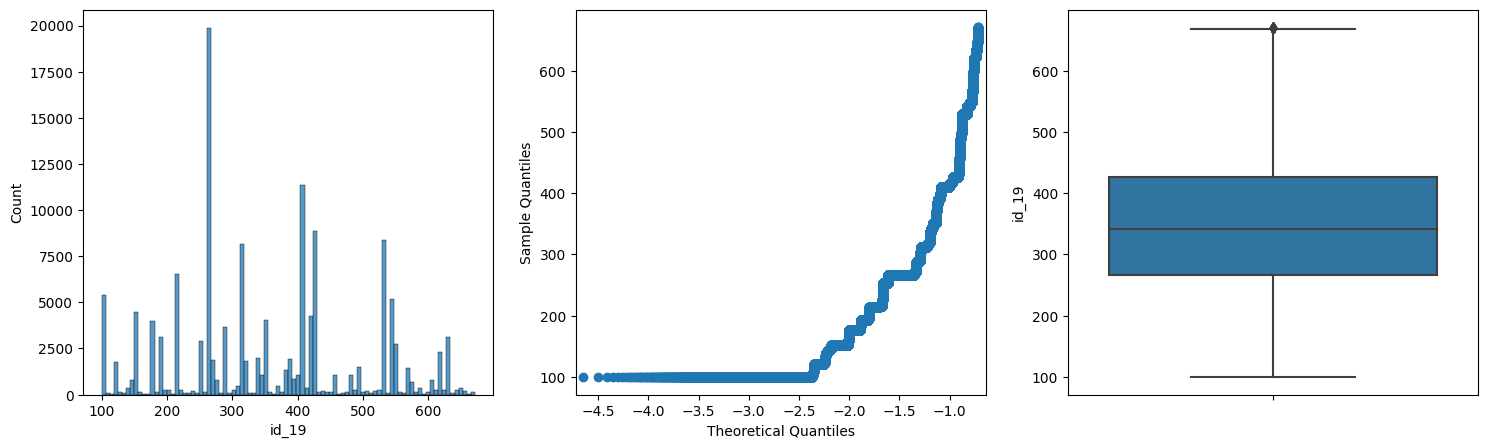

In [124]:
Outlier_Detect_IQR(data = train_df, col = 'id_19')

In [125]:
#discretize id_19  outliers
train_df['id_19'] = Outliers_Handle_Discretization(data = train_df, col='id_19')

## id_20

In [126]:
train_df['id_20'].value_counts(normalize=True)

507.0    0.160210
222.0    0.079455
325.0    0.058401
533.0    0.047472
214.0    0.040672
           ...   
255.0    0.000007
640.0    0.000007
219.0    0.000007
459.0    0.000007
329.0    0.000007
Name: id_20, Length: 394, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 887.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 56.5
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 819.3826663602875
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -11.617333639712456
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


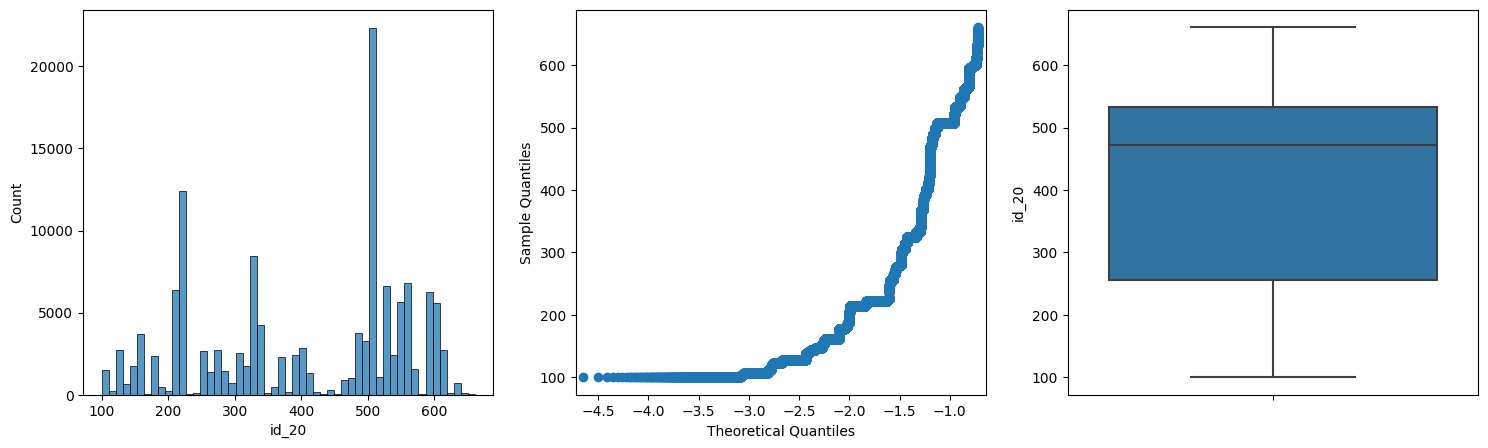

In [127]:
Outlier_Detect_IQR(data = train_df, col = 'id_20')

This feature may be uniform distribution

## id_21

In [128]:
train_df['id_21'].value_counts(normalize=True)

252.0    0.492731
228.0    0.046327
255.0    0.021128
596.0    0.019965
576.0    0.019577
           ...   
759.0    0.000194
758.0    0.000194
158.0    0.000194
753.0    0.000194
841.0    0.000194
Name: id_21, Length: 490, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 603.75
1.2 the potential outliers above 1.5IQR amount is : 821
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
999999.0         821
dtype: int64
1.4 the lower bound value is -99.75
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 159738.40187051755
2.2 the potential outliers above 1.5IQR amount is : 821
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
999999.0         821
dtype: int64
2.4 the lower bound is 159034.90187051755
2.5 the potential outliers below 1.5IQR amount is : 4338
2.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
252.0            2542
228.0            

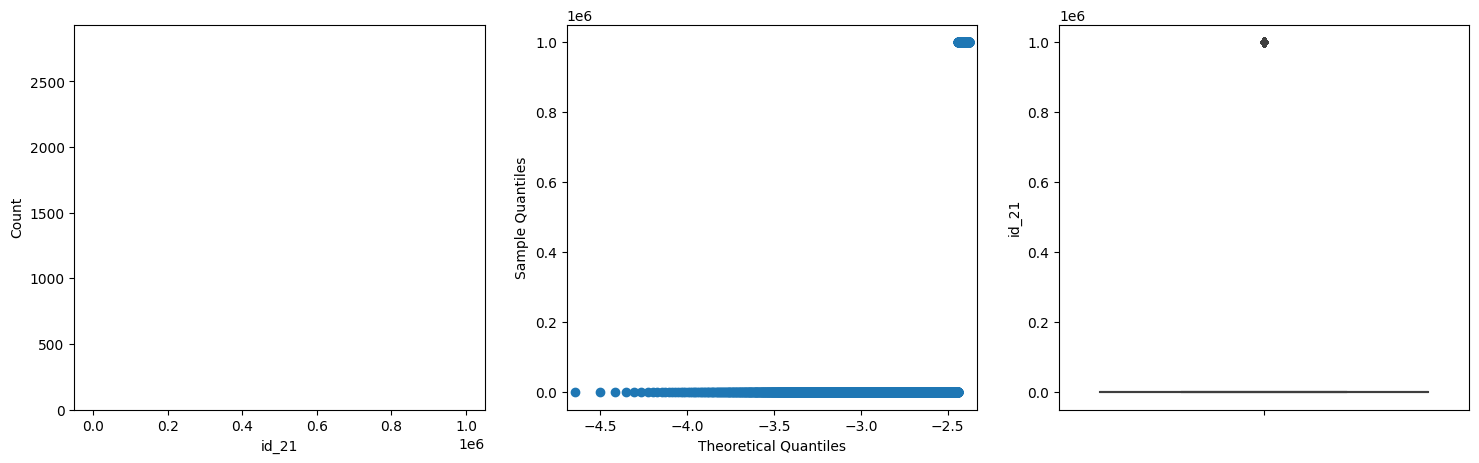

In [208]:
Outlier_Detect_IQR(data = train_df, col = 'id_21')

## id_22

In [209]:
train_df['id_22'].value_counts(normalize=True)

14.0    0.916231
41.0    0.062101
33.0    0.007352
17.0    0.001354
21.0    0.001354
39.0    0.001161
35.0    0.000967
36.0    0.000967
12.0    0.000967
31.0    0.000967
22.0    0.000967
20.0    0.000774
24.0    0.000774
26.0    0.000774
28.0    0.000580
42.0    0.000580
19.0    0.000387
38.0    0.000387
18.0    0.000193
44.0    0.000193
43.0    0.000193
40.0    0.000193
23.0    0.000193
37.0    0.000193
10.0    0.000193
Name: id_22, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 14.0
1.2 the potential outliers above 1.5IQR amount is : 427
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
41.0             321
33.0              38
17.0               7
21.0               7
39.0               6
36.0               5
22.0               5
35.0               5
31.0               5
26.0               4
24.0               4
20.0               4
28.0               3
42.0               3
38.0               2
19.0               2
37.0               1
43.0               1
23.0               1
40.0               1
18.0               1
44.0               1
dtype: int64
1.4 the lower bound value is 14.0
1.5 the potential outliers below 1.5IQR amount is : 6
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
12.0             5
10.0             1
dtype: int64
-------------------------------------------------------------------------------------------------

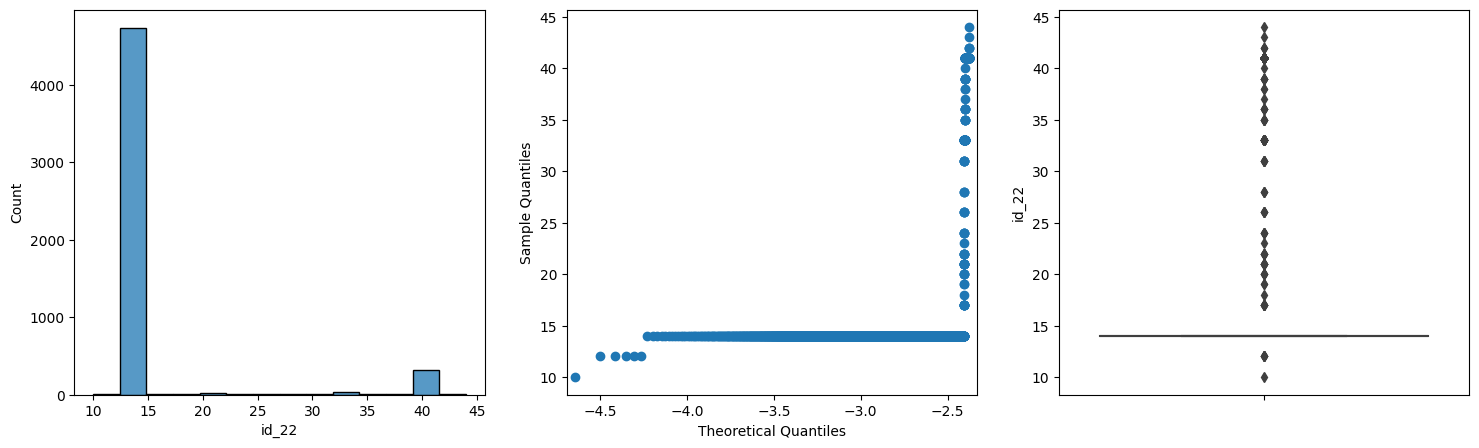

In [210]:
Outlier_Detect_IQR(data = train_df, col = 'id_22')

According to IQR detection  and  percentage of feature values,  what id_22 is deleted will be a good choice

## id_23

In [211]:
train_df['id_23'].value_counts(normalize=True)

IP_PROXY:TRANSPARENT    0.674985
IP_PROXY:ANONYMOUS      0.207197
IP_PROXY:HIDDEN         0.117818
Name: id_23, dtype: float64

In [212]:
#encoding firstly
train_df['id_23'] = Encoder_With_Label(data = train_df, col = 'id_23')

1. when median as the foundment value

1.1 the upper bound value is 3.5
1.2 the potential outliers above 1.5IQR amount is : 0
1.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
1.4 the lower bound value is 0.5
1.5 the potential outliers below 1.5IQR amount is : 1071
1.6 the potential outliers below 1.5IQR values distribution is: 
 outlier_below
0.0              1071
dtype: int64
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 2.9677886962890625
2.2 the potential outliers above 1.5IQR amount is : 0
2.3 the potential outliers above 1.5IQR values distribution is: 
 Series([], dtype: int64)
2.4 the lower bound is -0.0322113037109375
2.5 the potential outliers below 1.5IQR amount is : 0
2.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)


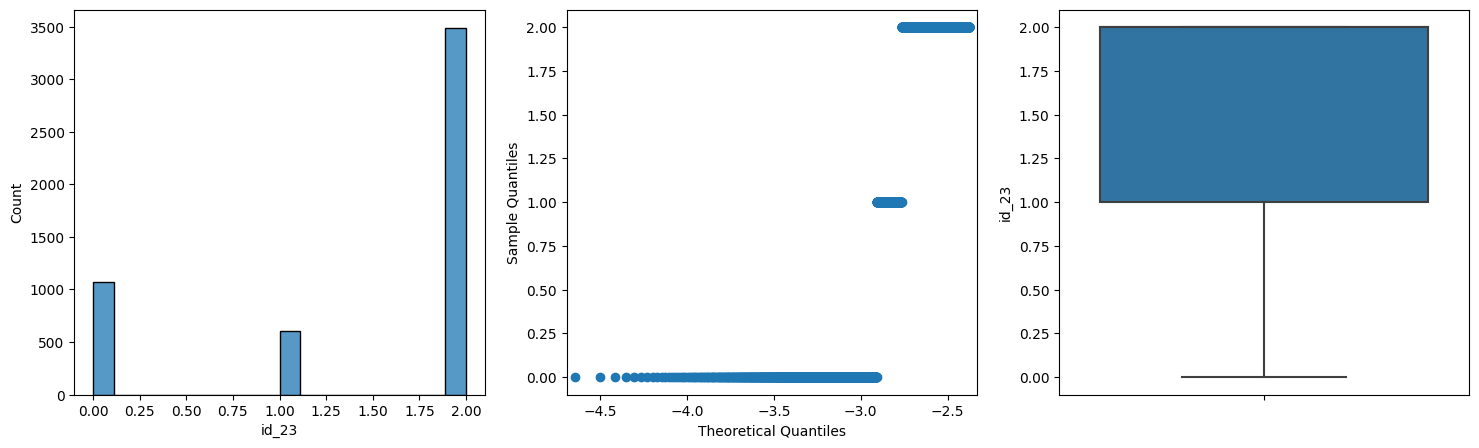

In [213]:
Outlier_Detect_IQR(data = train_df, col = 'id_23')

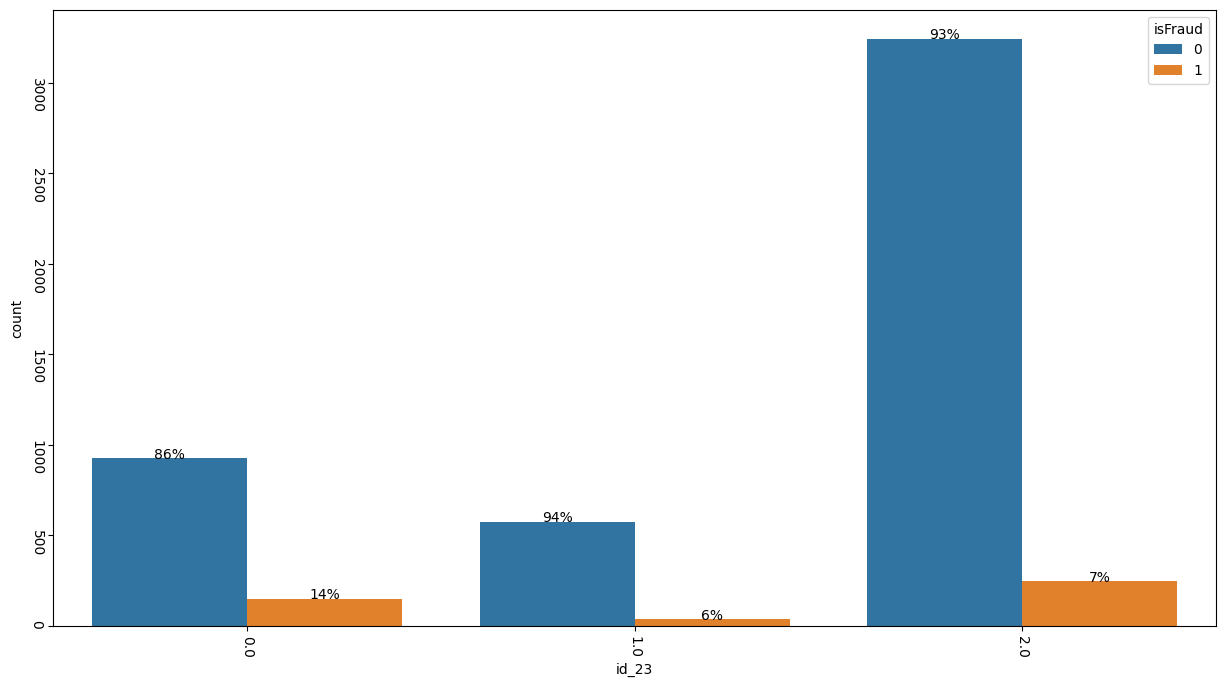

In [214]:
Plot_Cate_Correlation(data = train_df, col_A= 'id_23', hue_B='isFraud')

do nothing with id_23 but encoding

## id_24

In [215]:
train_df['id_24'].value_counts(normalize=True)

11.0    0.593427
15.0    0.335791
16.0    0.046345
18.0    0.007794
21.0    0.006952
24.0    0.002528
17.0    0.001896
26.0    0.001685
25.0    0.001475
19.0    0.001053
12.0    0.000843
23.0    0.000211
Name: id_24, dtype: float64

1. when median as the foundment value

1.1 the upper bound value is 17.0
1.2 the potential outliers above 1.5IQR amount is : 103
1.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
18.0             37
21.0             33
24.0             12
26.0              8
25.0              7
19.0              5
23.0              1
dtype: int64
1.4 the lower bound value is 5.0
1.5 the potential outliers below 1.5IQR amount is : 0
1.6 the potential outliers below 1.5IQR values distribution is: 
 Series([], dtype: int64)
----------------------------------------------------------------------------------------------------
2. when mean as the foundment value

2.1 the upper bound value is 18.80092690120076
2.2 the potential outliers above 1.5IQR amount is : 66
2.3 the potential outliers above 1.5IQR values distribution is: 
 outlier_above
21.0             33
24.0             12
26.0              8
25.0              7
19.0              5
23.0              1
dtype: int64
2.4 the

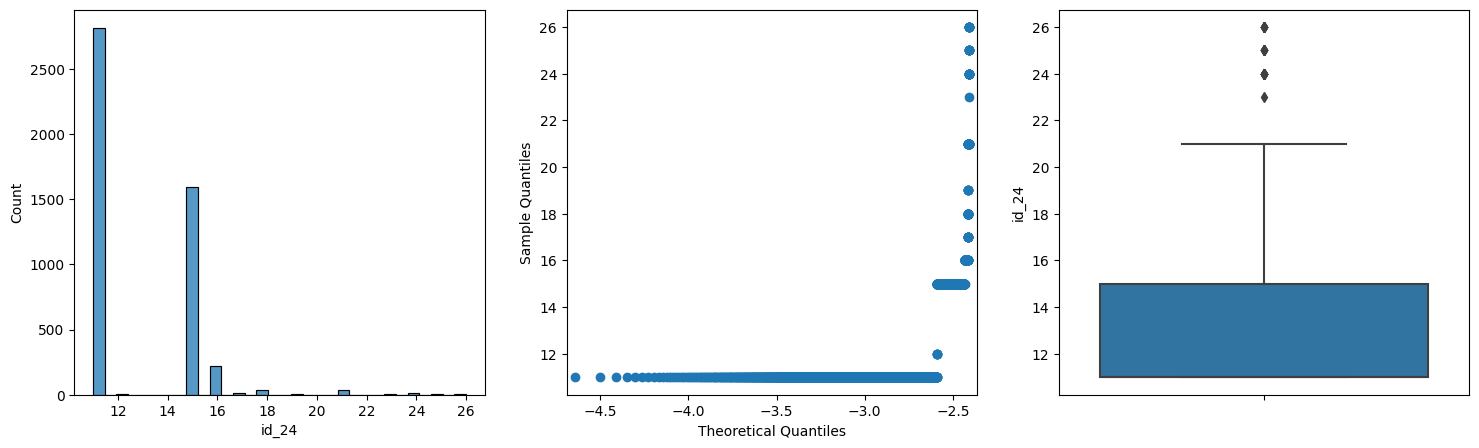

In [216]:
Outlier_Detect_IQR(data = train_df, col ='id_24')

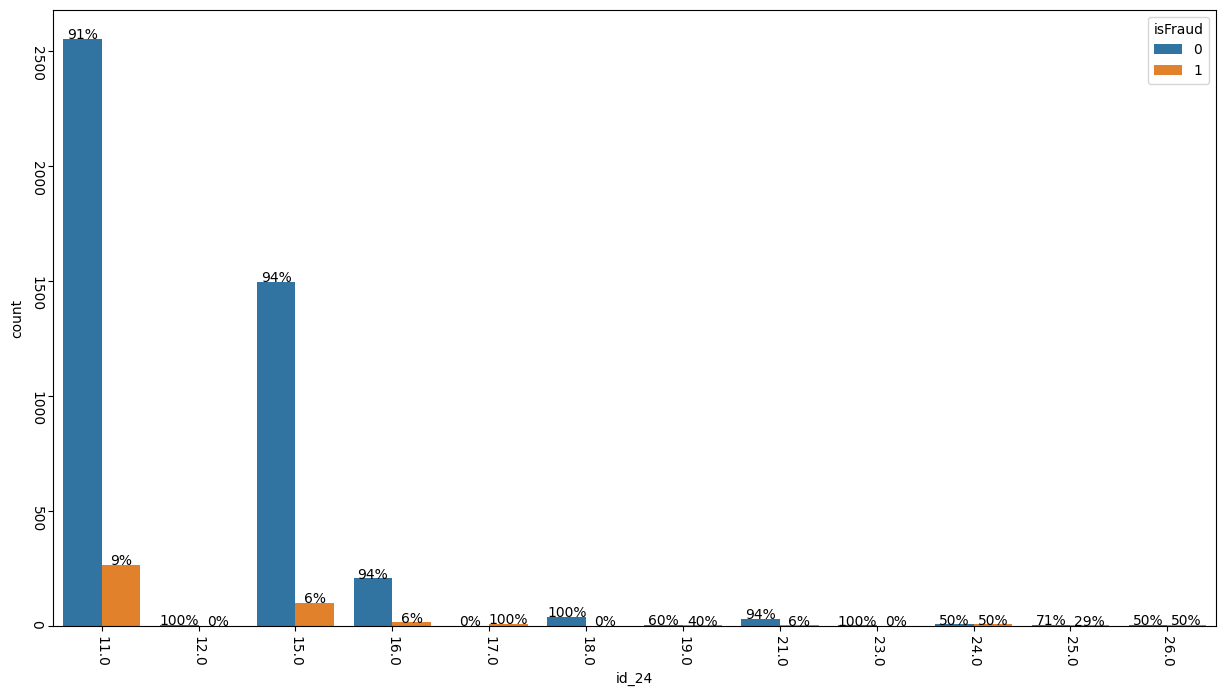

In [217]:
Plot_Cate_Correlation(data =  train_df, col_A='id_24', hue_B='isFraud')

In [223]:
temp_data = train_df.loc[:,['id_24','isFraud']].copy()
temp_data['id_24'] = temp_data['id_24'].apply(lambda x: x if x ==11 or x == 15 else 9999)
Plot_Cate_Correlation(temp_data,col_A='id_24', hue_B='isFraud')

In [227]:
train_df['id_24'].value_counts()

11.0    2817
15.0    1594
16.0     220
18.0      37
21.0      33
24.0      12
17.0       9
26.0       8
25.0       7
19.0       5
12.0       4
23.0       1
Name: id_24, dtype: int64

In [77]:
print(cate_col_list, end = '')

['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [142]:
train_df.shape

(590540, 433)

### 采用多重插补算法对缺失值进行填充

In [13]:
train_y = train_df['isFraud']
# train_df.drop(labels = ['isFraud'], axis = 1,inplace = True)

In [62]:
#get the str or object type feature names
str_col_list = [x for x in train_df.columns if str(train_df[x].dtype)[:3] not in ['int','flo']]

### encoding these categorical features to digital value firstly for missing values imputing

In [15]:
print(str_col_list,end = "")

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [16]:
for col in str_col_list:
    #根据取值观察，可以采用label encoding
    print(col)
    print(train_df[col].value_counts())
    print('-----------------------------')

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64
-----------------------------
card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64
-----------------------------
card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64
-----------------------------
P_emaildomain
gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter

In [17]:
for col in str_col_list:
    #根据取值观察，可以采用label encoding
    train_df[col] = Encoder_With_Label(train_df,col)

### 通过MICE算法对数据集进行填充

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(31), float64(399), int64(4)
memory usage: 1.9 GB


In [19]:
print(missing_col_list,end = "")

['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V

In [20]:
missing_col_cate = [x for x in missing_col_list if x in cate_col_list]
missing_col_cont = [x for x in missing_col_list if x in cont_col_list]

# confirm the type of Missing mechanism
there are three misssing mechanism , MCAR, MAR, MNAR.
Different missing mechanism have different methods to fill Nan value
<hr>
So, we should confirm the mechanism of feature which contains Nan values,firstly

# card2

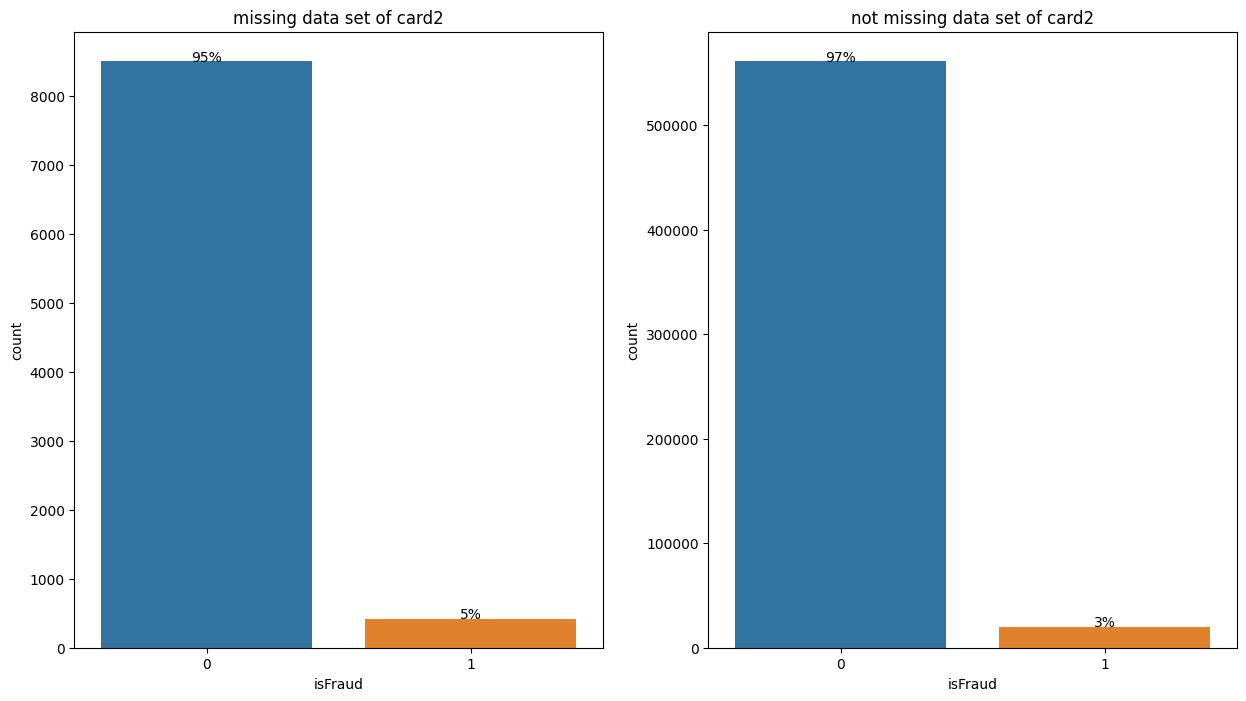

In [21]:
Missing_Detect_Diff_Distribution(data = train_df,col_A = 'card2',col_B ='isFraud')

In [22]:
#可以看出card2在缺失子集和非缺失子集上，关于label的分布和相关性没有很大的差距，因此可以认定关于card2
#是随机缺失的, 可以采用众数和中位数进行填充
train_df['card2'].value_counts()
train_df[col] = Missing_Imputer(train_df,col = 'card2', method='median')

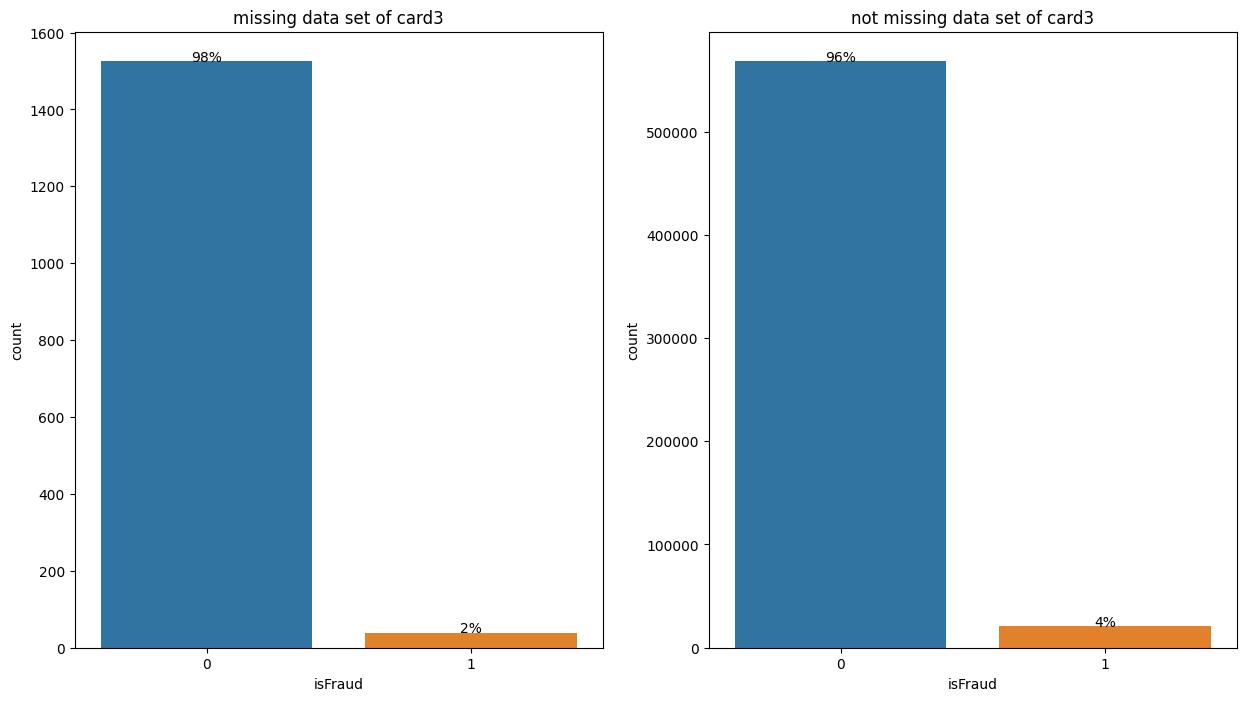

In [23]:
Missing_Detect_Diff_Distribution(train_df,col_A='card3',col_B='isFraud')

In [24]:
train_df['card3'].value_counts()
#根据数值分布，采用众数填充
train_df['card3'] = Missing_Imputer(train_df,col= 'card3',method='most_frequent')

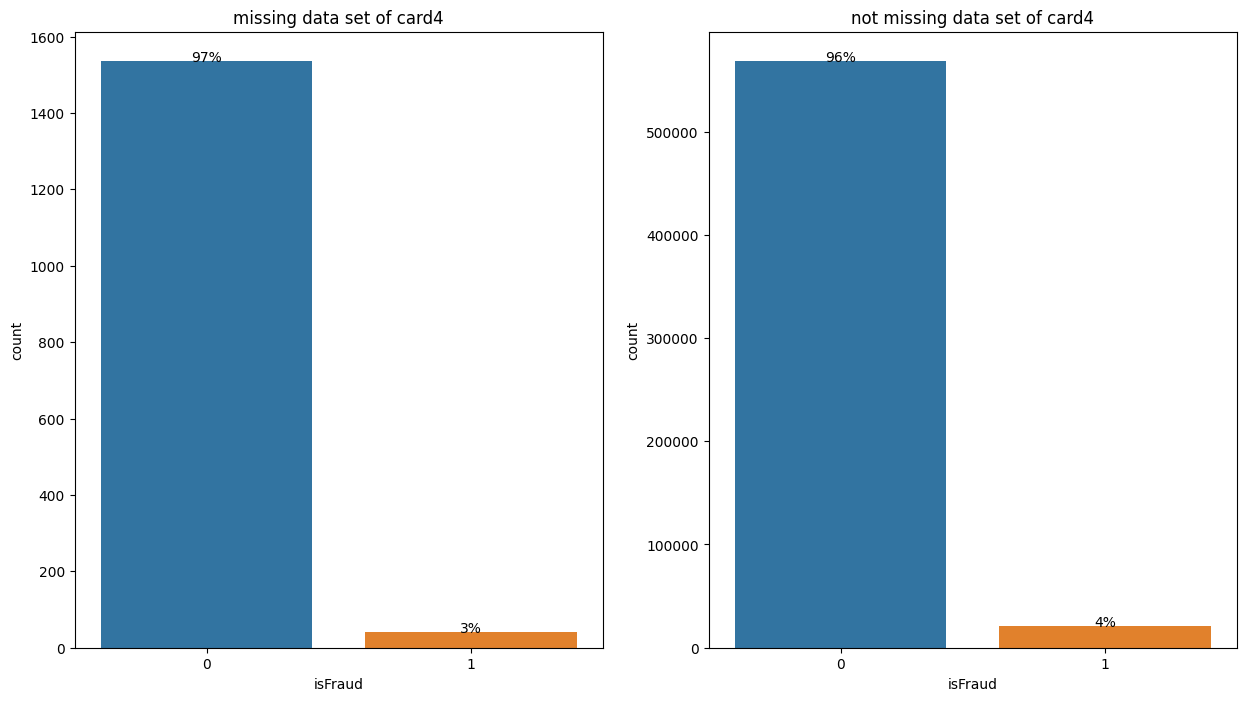

In [25]:
Missing_Detect_Diff_Distribution(train_df,col_A='card4',col_B='isFraud')

In [26]:
train_df['card4'].value_counts()
train_df['card4'] = Missing_Imputer(train_df,col='card4', method='most_frequent')

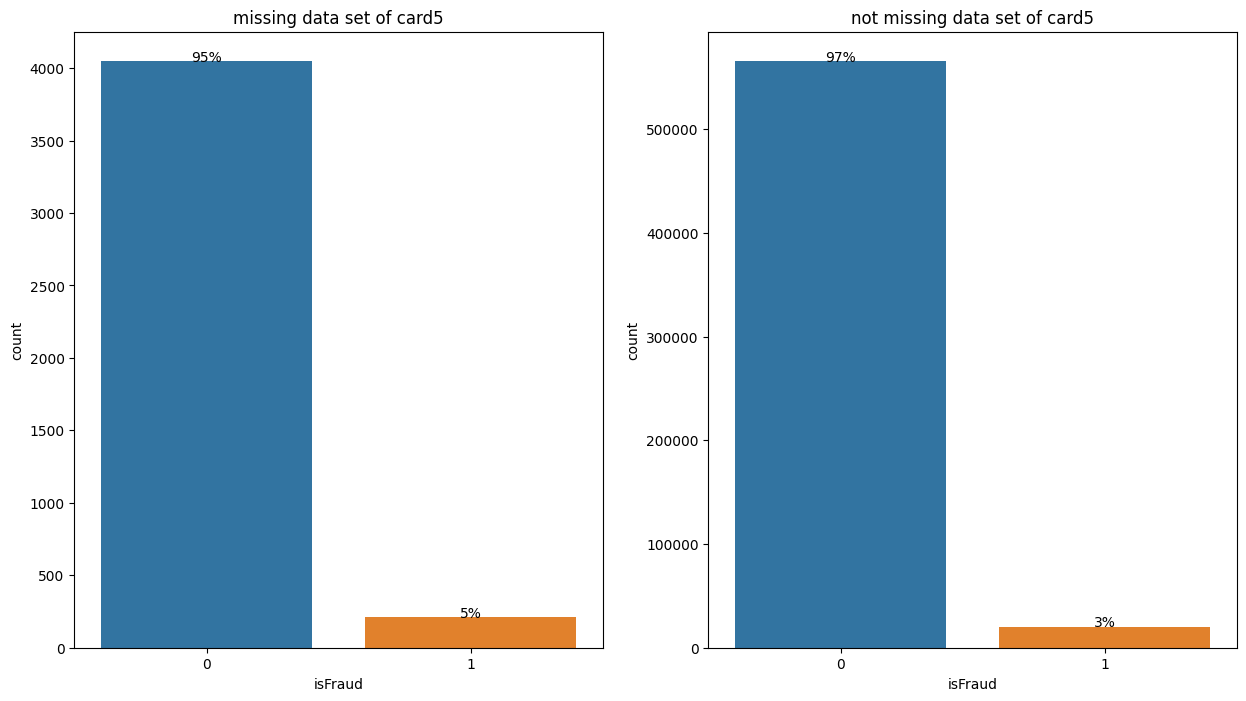

In [27]:
Missing_Detect_Diff_Distribution(train_df,col_A='card5', col_B='isFraud')

In [28]:
train_df['card5'].value_counts()
train_df['card5'] = Missing_Imputer(train_df, col = 'card5', method='most_frequent')

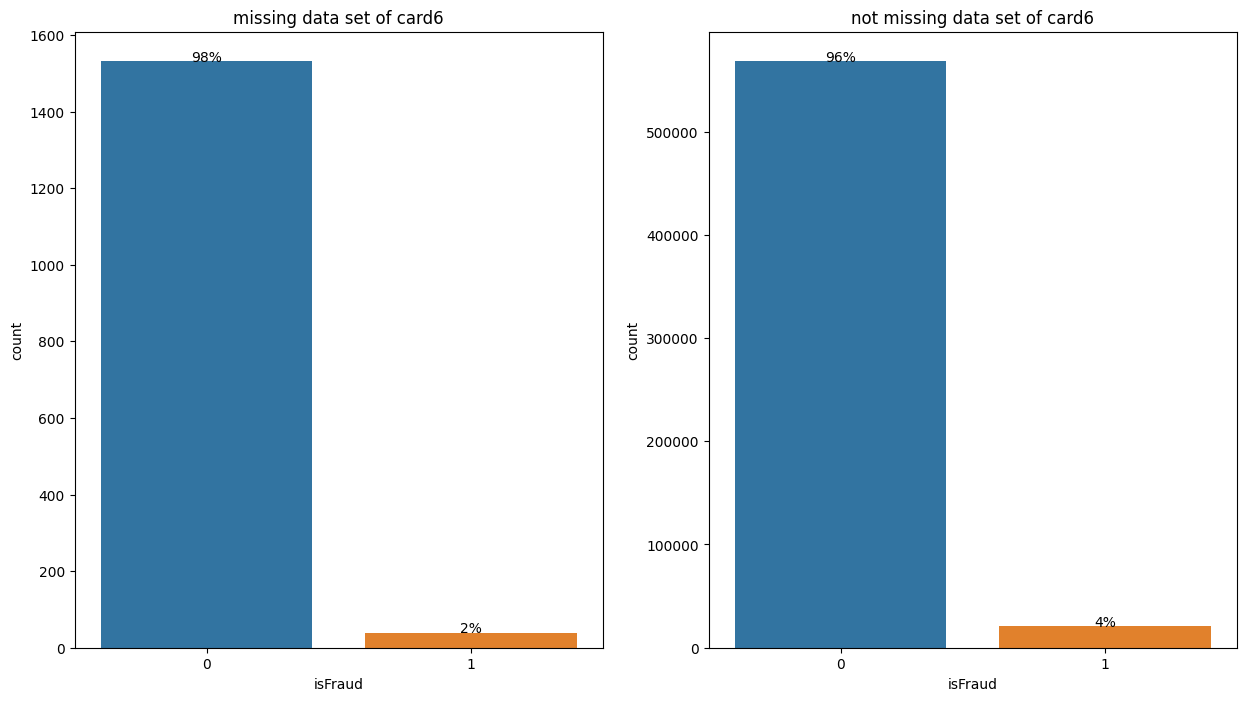

In [29]:
Missing_Detect_Diff_Distribution(train_df, col_A='card6', col_B='isFraud')

In [30]:
train_df['card6'].value_counts()
train_df['card6'] = Missing_Imputer(train_df, col='card6', method='most_frequent')

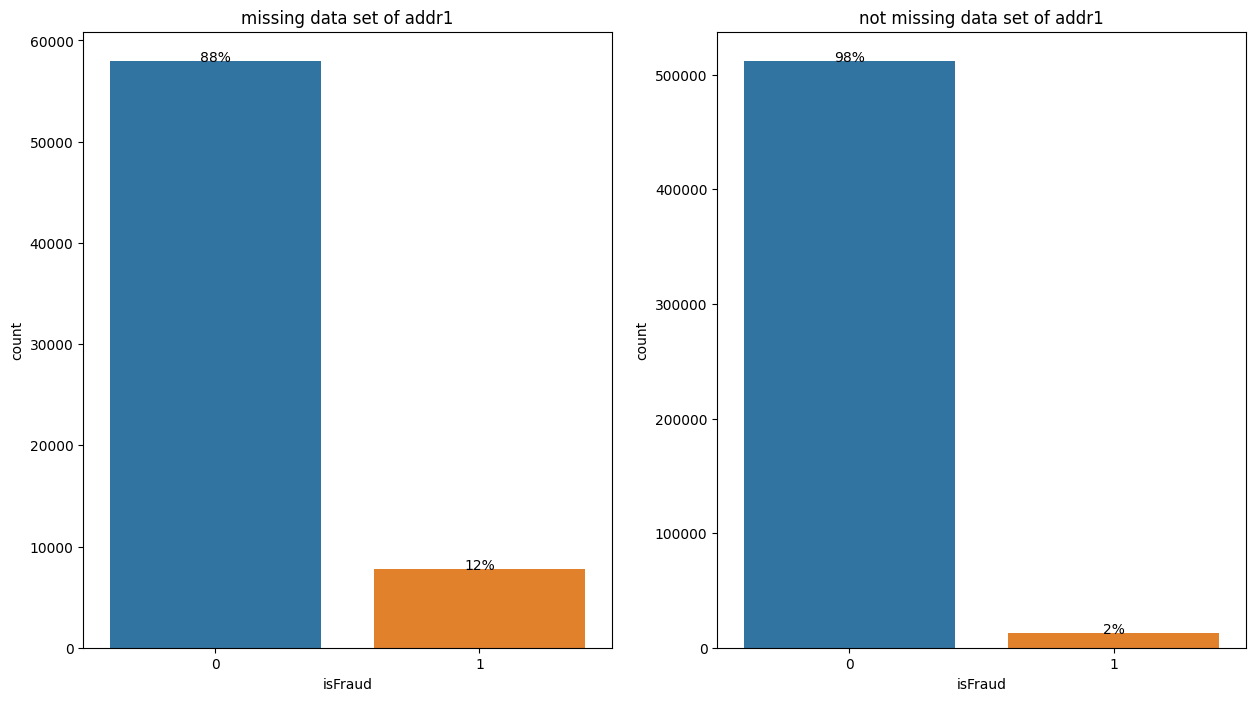

In [31]:
Missing_Detect_Diff_Distribution(train_df,col_A='addr1',col_B='isFraud')

In [32]:
train_df['addr1'].value_counts()
#从图示可以看出，addr1明显不是随机缺失的

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
462.0        1
128.0        1
481.0        1
120.0        1
340.0        1
Name: addr1, Length: 332, dtype: int64

In [33]:
for col in cate_col_list:
    if col != 'addr1':
        Missing_Compute_Corr(train_df,col_A='addr1',col_B=col)

the pearsonr corr between addr1 and ProductCD is: (-0.020724935453395713, 5.782031277445109e-51)
the spearmanr corr between addr1 and ProductCD is: SpearmanrResult(correlation=-0.03586154525085773, pvalue=6.707204209651741e-149)


the pearsonr corr between addr1 and P_emaildomain is: (-0.006707653624944092, 1.0234254473590504e-05)
the spearmanr corr between addr1 and P_emaildomain is: SpearmanrResult(correlation=-0.007777921849796041, pvalue=3.1177655843147526e-07)


the pearsonr corr between addr1 and R_emaildomain is: (-0.00382368852692855, 0.29817602583799235)
the spearmanr corr between addr1 and R_emaildomain is: SpearmanrResult(correlation=0.009919408267285573, pvalue=0.006956102721038218)


the pearsonr corr between addr1 and DeviceType is: (-0.017292959884056908, 7.935734801633329e-07)
the spearmanr corr between addr1 and DeviceType is: SpearmanrResult(correlation=-0.026793225815487324, pvalue=2.0104288980328322e-14)


the pearsonr corr between addr1 and DeviceInfo is: (0.030091

the pearsonr corr between addr1 and id_29 is: (-0.010592533873207827, 0.0024700726799117972)
the spearmanr corr between addr1 and id_29 is: SpearmanrResult(correlation=-0.025642404297401493, pvalue=2.323594042213911e-13)


the pearsonr corr between addr1 and id_30 is: (-0.012203090831853995, 0.0006956715365472413)
the spearmanr corr between addr1 and id_30 is: SpearmanrResult(correlation=-0.025884982933736585, pvalue=6.270843598946251e-13)


the pearsonr corr between addr1 and id_31 is: (-0.014229942921227931, 5.0764326461316914e-05)
the spearmanr corr between addr1 and id_31 is: SpearmanrResult(correlation=-0.02018845598359356, pvalue=8.971725437814846e-09)


the pearsonr corr between addr1 and id_32 is: (-0.012509235855533872, 0.0005073656295352655)
the spearmanr corr between addr1 and id_32 is: SpearmanrResult(correlation=-0.024455231924250115, pvalue=1.0617172013132074e-11)


the pearsonr corr between addr1 and id_33 is: (-0.01272298669706945, 0.0005886426867137958)
the spearmanr c

In [35]:
print(missing_col_cate,end = "")

['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']